#Library

In [ ]:
import pandas as pd

#Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#read data



In [ ]:
Catdf = pd.read_csv(r'/content/gdrive/MyDrive/dataset/employment_data.csv')

In [ ]:
print(Catdf.columns)

Index(['country', 'total_weekly_hours_worked(estimates_in_thousands)',
       'percentage_of_working_hrs_lost', 'percent_hours_lost_40hrs_per_week',
       'percent_hours_lost_48hrs_per_week', 'labour_dependency_ratio',
       'employed_female_25+_2019', 'employed_male_25+_2019',
       'ratio_of_weekly_hours_worked_by_population_age_15-64'],
      dtype='object')


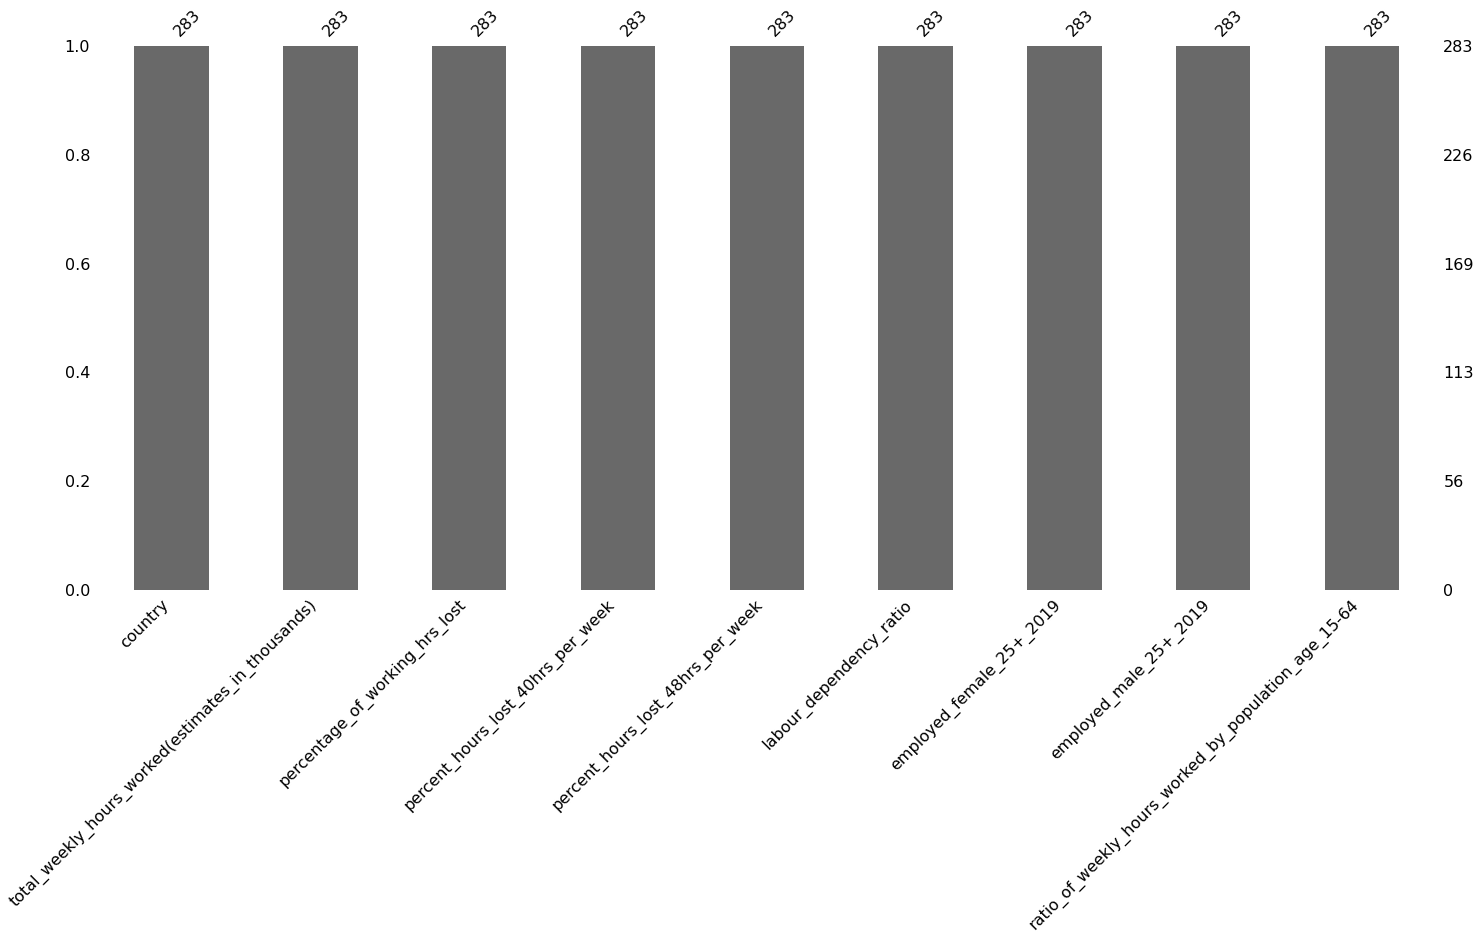

In [ ]:
import missingno as msno 
msno.bar(Catdf)

In [ ]:
Catdf.head()

,country,total_weekly_hours_worked(estimates_in_thousands),percentage_of_working_hrs_lost,percent_hours_lost_40hrs_per_week,percent_hours_lost_48hrs_per_week,labour_dependency_ratio,employed_female_25+_2019,employed_male_25+_2019,ratio_of_weekly_hours_worked_by_population_age_15-64
0,Afghanistan,350285.606,6.5,607.476,506.230,3.57,1334.243,5424.911,16.2
1,Angola,457913.433,8.6,1075.838,896.532,1.70,4612.109,4724.669,27.1
2,Albania,49922.483,3.9,51.087,42.572,1.77,500.112,651.870,25.5
3,United Arab Emirates,320690.368,9.3,824.579,687.149,0.41,996.030,5111.770,38.6
4,Argentina,525994.010,21.0,3492.559,2910.466,1.43,7264.330,9496.191,18.1


In [ ]:
catdf_selected=Catdf[['total_weekly_hours_worked(estimates_in_thousands)',
       'percentage_of_working_hrs_lost', 'percent_hours_lost_40hrs_per_week',
       'percent_hours_lost_48hrs_per_week', 'labour_dependency_ratio',
       'employed_female_25+_2019', 'employed_male_25+_2019',
       'ratio_of_weekly_hours_worked_by_population_age_15-64']]

In [ ]:
catdf_selected.head()

,total_weekly_hours_worked(estimates_in_thousands),percentage_of_working_hrs_lost,percent_hours_lost_40hrs_per_week,percent_hours_lost_48hrs_per_week,labour_dependency_ratio,employed_female_25+_2019,employed_male_25+_2019,ratio_of_weekly_hours_worked_by_population_age_15-64
0,350285.606,6.5,607.476,506.230,3.57,1334.243,5424.911,16.2
1,457913.433,8.6,1075.838,896.532,1.70,4612.109,4724.669,27.1
2,49922.483,3.9,51.087,42.572,1.77,500.112,651.870,25.5
3,320690.368,9.3,824.579,687.149,0.41,996.030,5111.770,38.6
4,525994.010,21.0,3492.559,2910.466,1.43,7264.330,9496.191,18.1


In [ ]:
employed_female_25_2019_MIN = catdf_selected["employed_female_25+_2019"].min()
employed_female_25_2019_MAX = catdf_selected["employed_female_25+_2019"].max()
print('Min and max employed female 25+ 2019', employed_female_25_2019_MIN, employed_female_25_2019_MAX)

employed_male_25_2019_MIN = catdf_selected["employed_male_25+_2019"].min()
employed_male_25_2019_MAX = catdf_selected["employed_male_25+_2019"].max()

print('Min and max employed male 25+ 2019', employed_male_25_2019_MIN, employed_male_25_2019_MAX)

Min and max employed female 25+ 2019 10.83 1117336.992
Min and max employed male 25+ 2019 15.21 1756545.519


In [ ]:
import numpy as np

df_employed_female_25_2019 = pd.cut(catdf_selected['employed_female_25+_2019'], bins=np.linspace(employed_female_25_2019_MIN, employed_female_25_2019_MAX, 21), labels=False)
df_employed_male_25_2019 = pd.cut(catdf_selected['employed_male_25+_2019'], bins=np.linspace(employed_male_25_2019_MIN, employed_male_25_2019_MAX, 21), labels=False)

catdf_selected.drop(["employed_female_25+_2019", "employed_male_25+_2019"], axis=1, inplace=True)

catdf_selected = pd.concat([catdf_selected, df_employed_female_25_2019, df_employed_male_25_2019], axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


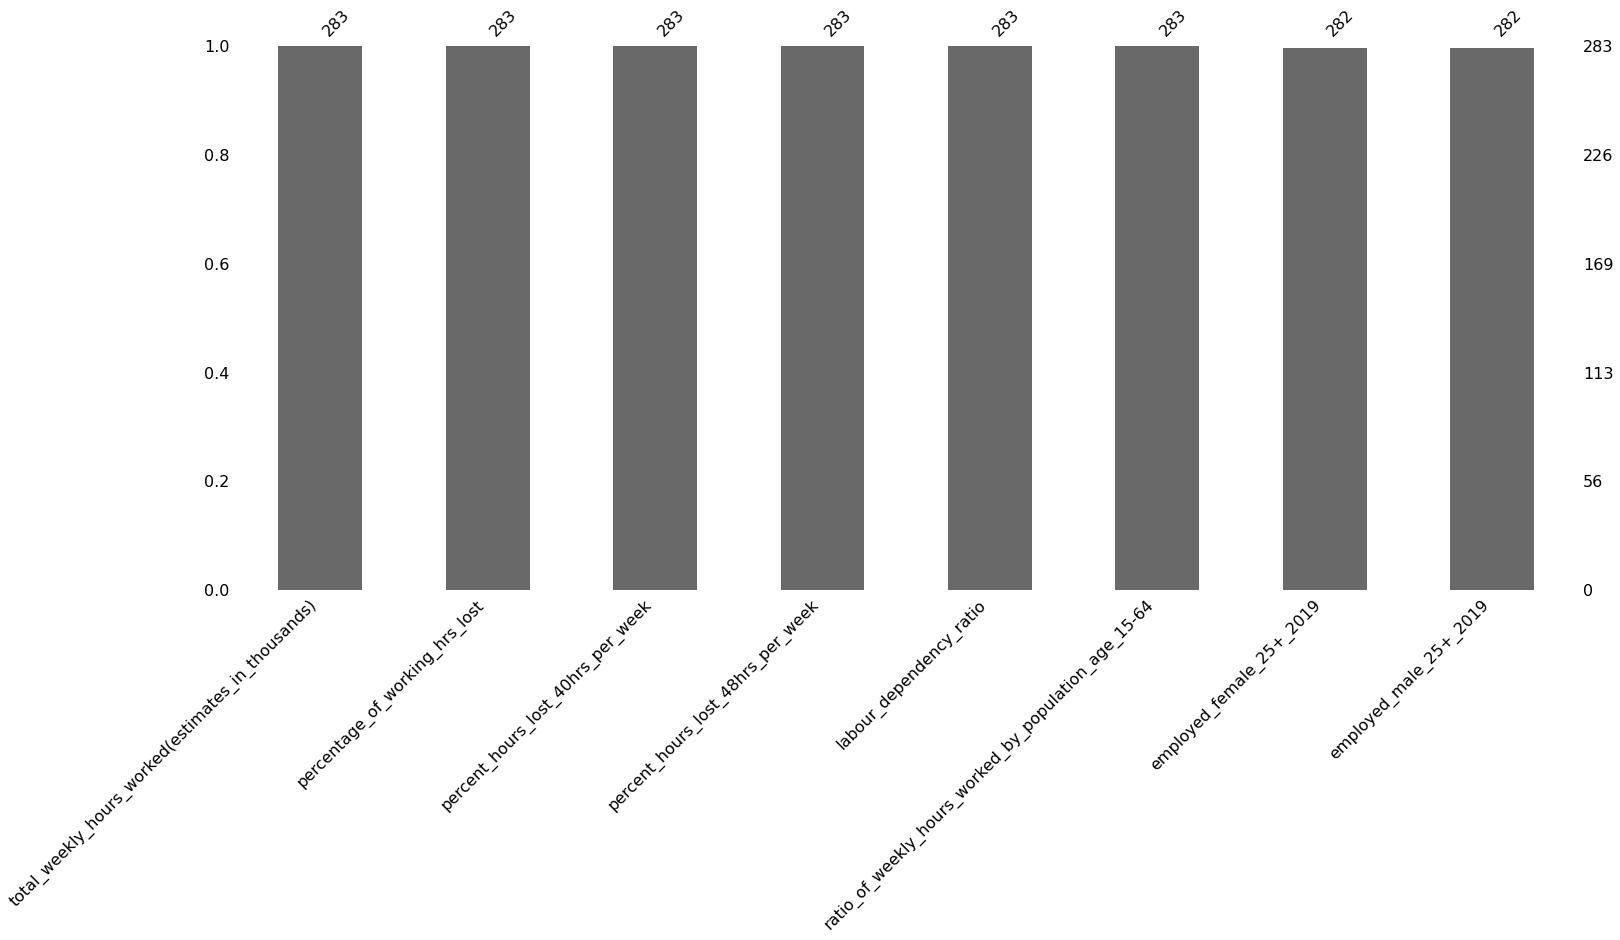

In [ ]:
msno.bar(catdf_selected)

In [ ]:
from sklearn.preprocessing import PowerTransformer

catdf_selected[catdf_selected.columns] = PowerTransformer(method='yeo-johnson', standardize=True, copy=True).fit_transform(catdf_selected[catdf_selected.columns])

print(catdf_selected)

     total_weekly_hours_worked(estimates_in_thousands)  ...  employed_male_25+_2019
0                                             0.030902  ...               -0.400587
1                                             0.141932  ...               -0.400587
2                                            -0.789882  ...               -0.400587
3                                            -0.005774  ...               -0.400587
4                                             0.199198  ...               -0.400587
..                                                 ...  ...                     ...
278                                          -0.544230  ...               -0.400587
279                                          -0.124207  ...               -0.400587
280                                           0.267418  ...               -0.400587
281                                          -0.090865  ...               -0.400587
282                                          -0.295835  ...               -0

In [ ]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Model

from tensorflow.keras.optimizers import Adam

class GAN():
    
    def __init__(self, gan_args):
        [self.batch_size, lr, self.noise_dim,
         self.data_dim, layers_dim] = gan_args

        self.generator = Generator(self.batch_size).\
            build_model(input_shape=(self.noise_dim,), dim=layers_dim, data_dim=self.data_dim)

        self.discriminator = Discriminator(self.batch_size).\
            build_model(input_shape=(self.data_dim,), dim=layers_dim)

        optimizer = Adam(lr, 0.5)

        # Build and compile the discriminator
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.noise_dim,))
        record = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(record)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def get_data_batch(self, train, batch_size, seed=0):
        # # random sampling - some samples will have excessively low or high sampling, but easy to implement
        # np.random.seed(seed)
        # x = train.loc[ np.random.choice(train.index, batch_size) ].values
        # iterate through shuffled indices, so every sample gets covered evenly

        start_i = (batch_size * seed) % len(train)
        stop_i = start_i + batch_size
        shuffle_seed = (batch_size * seed) // len(train)
        np.random.seed(shuffle_seed)
        train_ix = np.random.choice(list(train.index), replace=False, size=len(train))  # wasteful to shuffle every time
        train_ix = list(train_ix) + list(train_ix)  # duplicate to cover ranges past the end of the set
        x = train.loc[train_ix[start_i: stop_i]].values
        return np.reshape(x, (batch_size, -1))
        
    def train(self, data, train_arguments):
        [cache_prefix, epochs, sample_interval] = train_arguments
        
        data_cols = data.columns

        # Adversarial ground truths
        valid = np.ones((self.batch_size, 1))
        fake = np.zeros((self.batch_size, 1))

        for epoch in range(epochs):    
            # ---------------------
            #  Train Discriminator
            # ---------------------
            batch_data = self.get_data_batch(data, self.batch_size)
            noise = tf.random.normal((self.batch_size, self.noise_dim))

            # Generate a batch of new images
            gen_data = self.generator.predict(noise)
    
            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(batch_data, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
            # ---------------------
            #  Train Generator
            # ---------------------
            noise = tf.random.normal((self.batch_size, self.noise_dim))
            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)
    
            # Plot the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
    
            # If at save interval => save generated events
            if epoch % sample_interval == 0:
                #Test here data generation step
                # save model checkpoints
                model_checkpoint_base_name = 'model/' + cache_prefix + '_{}_model_weights_step_{}.h5'
                self.generator.save_weights(model_checkpoint_base_name.format('generator', epoch))
                self.discriminator.save_weights(model_checkpoint_base_name.format('discriminator', epoch))

                #Here is generating the data
                z = tf.random.normal((432, self.noise_dim))
                gen_data = self.generator(z)
                print('generated_data')

    def save(self, path, name):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        model_path = os.path.join(path, name)
        self.generator.save_weights(model_path)  # Load the generator
        return
    
    def load(self, path):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        self.generator = Generator(self.batch_size)
        self.generator = self.generator.load_weights(path)
        return self.generator
    
class Generator():
    def __init__(self, batch_size):
        self.batch_size=batch_size
        
    def build_model(self, input_shape, dim, data_dim):
        input= Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim, activation='relu')(input)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dense(dim * 4, activation='relu')(x)
        x = Dense(data_dim)(x)
        return Model(inputs=input, outputs=x)

class Discriminator():
    def __init__(self,batch_size):
        self.batch_size=batch_size
    
    def build_model(self, input_shape, dim):
        input = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim * 4, activation='relu')(input)
        x = Dropout(0.1)(x)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dropout(0.1)(x)
        x = Dense(dim, activation='relu')(x)
        x = Dense(1, activation='sigmoid')(x)
        return Model(inputs=input, outputs=x)

In [ ]:
data_cols =catdf_selected.columns

In [ ]:
#Define the GAN and training parameters
noise_dim = 32
dim = 128
batch_size = 32

log_step = 100
epochs = 5000+1
learning_rate = 5e-4
models_dir = 'model'

catdf_selected[data_cols] = catdf_selected[data_cols]

print(catdf_selected.shape[1])

gan_args = [batch_size, learning_rate, noise_dim, catdf_selected.shape[1], dim]
train_args = ['', epochs, log_step]

8


In [ ]:
!mkdir model

In [ ]:
model = GAN

#Training the GAN model chosen: Vanilla GAN, CGAN, DCGAN, etc.
synthesizer = model(gan_args)
synthesizer.train(catdf_selected, train_args)

Streaming output truncated to the last 5000 lines.
51 [D loss: 0.445732, acc.: 87.50%] [G loss: 0.954879]
52 [D loss: 0.493492, acc.: 82.81%] [G loss: 0.890354]
53 [D loss: 0.508140, acc.: 75.00%] [G loss: 0.792494]
54 [D loss: 0.532153, acc.: 73.44%] [G loss: 0.781301]
55 [D loss: 0.659864, acc.: 60.94%] [G loss: 0.704425]
56 [D loss: 0.648930, acc.: 56.25%] [G loss: 0.578902]
57 [D loss: 0.886480, acc.: 54.69%] [G loss: 0.566121]
58 [D loss: 0.664828, acc.: 59.38%] [G loss: 0.547430]
59 [D loss: 0.851387, acc.: 54.69%] [G loss: 0.641143]
60 [D loss: 0.570914, acc.: 68.75%] [G loss: 0.833585]
61 [D loss: 0.501265, acc.: 84.38%] [G loss: 1.072190]
62 [D loss: 0.434278, acc.: 89.06%] [G loss: 1.189247]
63 [D loss: 0.439050, acc.: 85.94%] [G loss: 1.199206]
64 [D loss: 0.426564, acc.: 90.62%] [G loss: 1.169315]
65 [D loss: 0.443699, acc.: 89.06%] [G loss: 1.039306]
66 [D loss: 0.498739, acc.: 81.25%] [G loss: 0.956490]
67 [D loss: 0.533676, acc.: 71.88%] [G loss: 0.866341]
68 [D loss: 0.

In [ ]:
!mkdir model/gan
!mkdir model/gan/saved

mkdir: cannot create directory ‘model/gan’: File exists
mkdir: cannot create directory ‘model/gan/saved’: File exists


In [ ]:
synthesizer.generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 32)]                0         
_________________________________________________________________
dense (Dense)                (32, 128)                 4224      
_________________________________________________________________
dense_1 (Dense)              (32, 256)                 33024     
_________________________________________________________________
dense_2 (Dense)              (32, 512)                 131584    
_________________________________________________________________
dense_3 (Dense)              (32, 8)                   4104      
Total params: 172,936
Trainable params: 172,936
Non-trainable params: 0
_________________________________________________________________


In [ ]:
synthesizer.discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(32, 8)]                 0         
_________________________________________________________________
dense_4 (Dense)              (32, 512)                 4608      
_________________________________________________________________
dropout (Dropout)            (32, 512)                 0         
_________________________________________________________________
dense_5 (Dense)              (32, 256)                 131328    
_________________________________________________________________
dropout_1 (Dropout)          (32, 256)                 0         
_________________________________________________________________
dense_6 (Dense)              (32, 128)                 32896     
_________________________________________________________________
dense_7 (Dense)              (32, 1)                   129 

In [ ]:
models = {'GAN': ['GAN', False, synthesizer.generator]}

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Setup parameters visualization parameters
seed = 17
test_size = 50 # number of fraud cases
noise_dim = 32

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
print(len(catdf_selected))

283


No handles with labels found to put in legend.


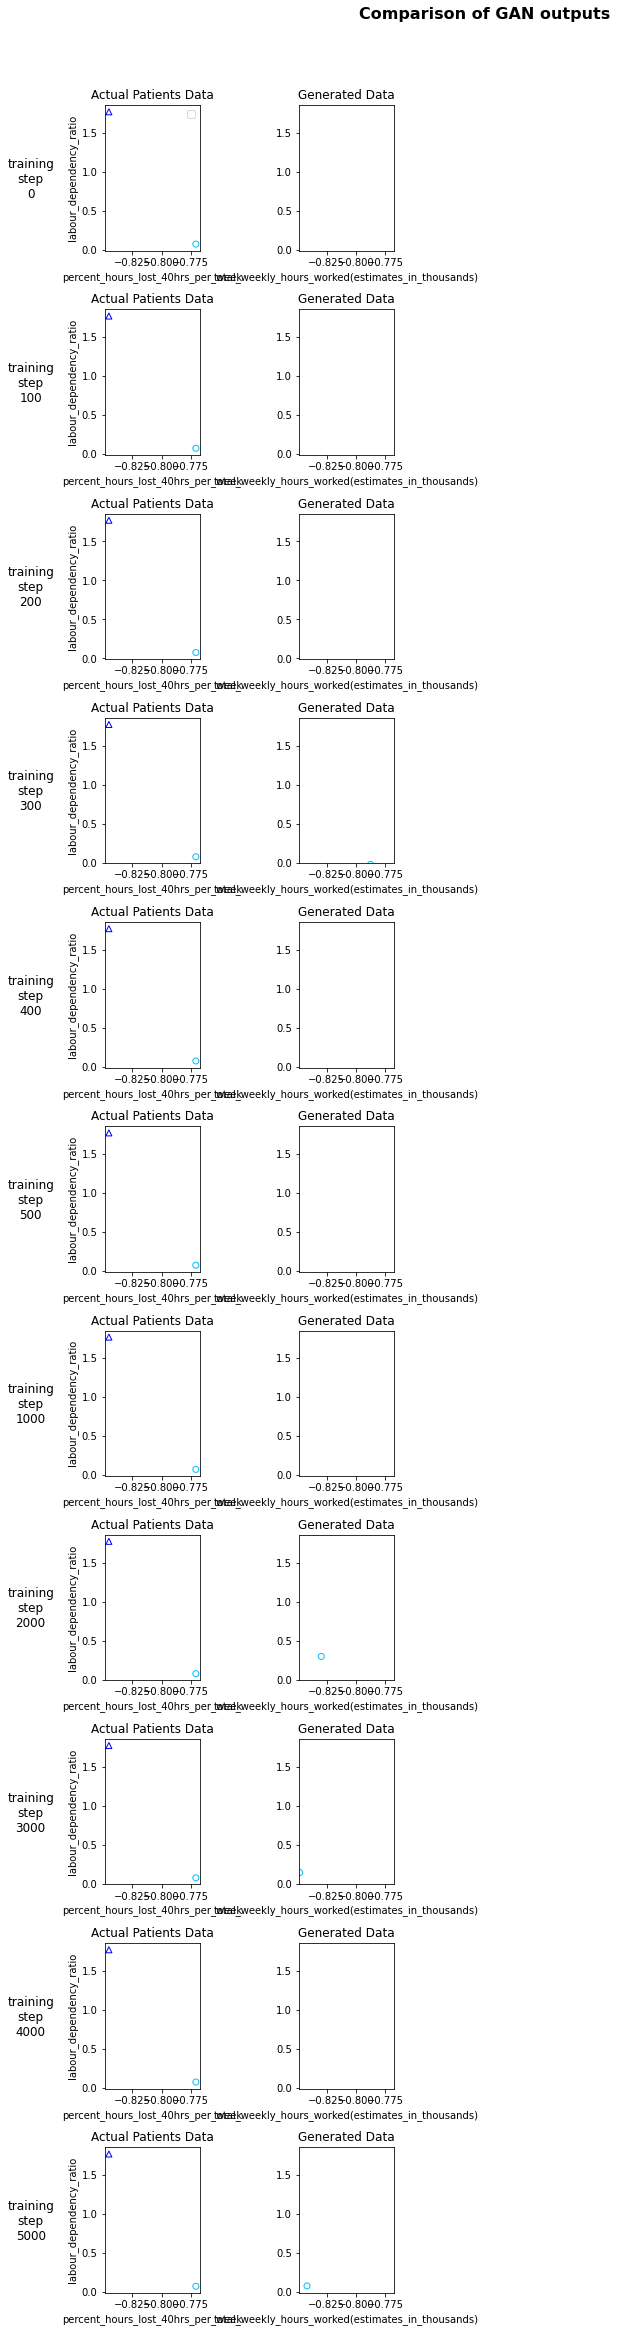

In [ ]:

real = synthesizer.get_data_batch(train=catdf_selected, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols)

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']

col1, col2 = 'percent_hours_lost_40hrs_per_week', 'labour_dependency_ratio'

base_dir = 'model/'

#Actual fraud data visualization
model_steps = [ 0, 100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(14,rows*3))

for model_step_ix, model_step in enumerate(model_steps):        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker in zip(real_samples.groupby('percentage_of_working_hrs_lost'), colors, markers):
        plt.scatter( group[1][[col1]], group[1][[col2]], marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Patients Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
    
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    i=0
    [model_name, with_class, generator_model] = models['GAN']

    generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

    ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

    g_z = generator_model.predict(z)
    gen_samples = pd.DataFrame(g_z, columns=data_cols)
    gen_samples.to_csv('Generated_sample.csv')
    plt.scatter( gen_samples[[col1]], gen_samples[[col2]], marker=markers[0], edgecolors=colors[0], facecolors='none' )
    plt.title("Generated Data")   
    plt.xlabel(data_cols[0])
    ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

plt.savefig('Comparison_of_GAN_outputs.png')

In [ ]:
real_samples.head(5)

,total_weekly_hours_worked(estimates_in_thousands),percentage_of_working_hrs_lost,percent_hours_lost_40hrs_per_week,percent_hours_lost_48hrs_per_week,labour_dependency_ratio,ratio_of_weekly_hours_worked_by_population_age_15-64,employed_female_25+_2019,employed_male_25+_2019
0,0.787439,0.133794,0.731085,0.748149,1.135053,-0.712946,-0.435678,-0.400587
1,1.858840,-1.150123,1.562552,1.551665,-1.680527,1.930582,2.341652,2.529174
2,-1.622984,1.007034,-1.135353,-1.163918,0.536213,-0.829180,-0.435678,-0.400587
3,-1.637403,1.278864,-1.108610,-1.135368,-0.782156,0.475797,-0.435678,-0.400587
4,-0.089954,1.554555,0.148518,0.168770,0.478292,0.091991,-0.435678,-0.400587


In [ ]:
generated_numerical_data = PowerTransformer.inverse_transform(real_samples)

TypeError: ignored

#New method

**Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
%tensorflow_version 1.x
print(tf.__version__)

import warnings
warnings.filterwarnings("ignore")

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import concatenate
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
import scipy.stats

TensorFlow is already loaded. Please restart the runtime to change versions.
2.7.0


 **Reading Data**

***Car information dataset***

In [2]:
dataFrame = pd.read_csv(r"/content/autoscout24-germany-dataset.csv")
dataFrame

,mileage,make,model,fuel,gear,offerType,price,hp,year
0,235000,BMW,316,Diesel,Manual,Used,6800,116.0,2011
1,92800,Volkswagen,Golf,Gasoline,Manual,Used,6877,122.0,2011
2,149300,SEAT,Exeo,Gasoline,Manual,Used,6900,160.0,2011
3,96200,Renault,Megane,Gasoline,Manual,Used,6950,110.0,2011
4,156000,Peugeot,308,Gasoline,Manual,Used,6950,156.0,2011
...,...,...,...,...,...,...,...,...,...
46400,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46401,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46402,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46403,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021


In [3]:
dataFrame=dataFrame.dropna()
dataFrame

,mileage,make,model,fuel,gear,offerType,price,hp,year
0,235000,BMW,316,Diesel,Manual,Used,6800,116.0,2011
1,92800,Volkswagen,Golf,Gasoline,Manual,Used,6877,122.0,2011
2,149300,SEAT,Exeo,Gasoline,Manual,Used,6900,160.0,2011
3,96200,Renault,Megane,Gasoline,Manual,Used,6950,110.0,2011
4,156000,Peugeot,308,Gasoline,Manual,Used,6950,156.0,2011
...,...,...,...,...,...,...,...,...,...
46400,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46401,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46402,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46403,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021


In [4]:
numData = dataFrame.select_dtypes("number")
catData = dataFrame.select_dtypes("object")

In [ ]:
numData

,mileage,price,hp,year
0,235000,6800,116.0,2011
1,92800,6877,122.0,2011
2,149300,6900,160.0,2011
3,96200,6950,110.0,2011
4,156000,6950,156.0,2011
...,...,...,...,...
46400,99,12990,71.0,2021
46401,99,12990,71.0,2021
46402,99,12990,71.0,2021
46403,99,12990,71.0,2021


In [5]:
catData

,make,model,fuel,gear,offerType
0,BMW,316,Diesel,Manual,Used
1,Volkswagen,Golf,Gasoline,Manual,Used
2,SEAT,Exeo,Gasoline,Manual,Used
3,Renault,Megane,Gasoline,Manual,Used
4,Peugeot,308,Gasoline,Manual,Used
...,...,...,...,...,...
46400,Fiat,500,Electric/Gasoline,Manual,Pre-registered
46401,Fiat,500,Electric/Gasoline,Manual,Pre-registered
46402,Fiat,500,Electric/Gasoline,Manual,Pre-registered
46403,Fiat,500,Electric/Gasoline,Manual,Pre-registered


In [7]:
makeLen = len(catData['make'].dropna().unique())
modelLen = len(catData['model'].dropna().unique())
fuelLen = len(catData['fuel'].dropna().unique())
gearLen = len(catData['gear'].dropna().unique())
offerTypeLen = len(catData['offerType'].dropna().unique())

**Data scaleing**

In [154]:
MinMaxFit = MinMaxScaler()
scaleNumData=MinMaxFit.fit_transform(numData)

In [84]:
scaleNumData

array([[2.11500021e-01, 4.75475475e-03, 1.35453475e-01, 0.00000000e+00],
       [8.35200084e-02, 4.81898565e-03, 1.42520612e-01, 0.00000000e+00],
       [1.34370013e-01, 4.83817150e-03, 1.87279152e-01, 0.00000000e+00],
       ...,
       [8.91000089e-05, 9.91825158e-03, 8.24499411e-02, 1.00000000e+00],
       [8.91000089e-05, 9.91825158e-03, 8.24499411e-02, 1.00000000e+00],
       [8.91000089e-05, 9.91825158e-03, 8.24499411e-02, 1.00000000e+00]])

**Cat data replace with dummy data**

In [10]:
dummiCatData = pd.get_dummies(catData)
dummiCatData

,make_Abarth,make_Aixam,make_Alfa,make_Alpina,make_Alpine,make_Aston,make_Audi,make_BMW,make_Baic,make_Bentley,make_Brilliance,make_Cadillac,make_Chevrolet,make_Chrysler,make_Citroen,make_Corvette,make_Cupra,make_DFSK,make_DS,make_Dacia,make_Daihatsu,make_Dodge,make_Estrima,make_FISKER,make_Ferrari,make_Fiat,make_Ford,make_Honda,make_Hyundai,make_Infiniti,make_Isuzu,make_Iveco,make_Jaguar,make_Jeep,make_Kia,make_Lada,make_Lamborghini,make_Lancia,make_Land,make_Lexus,...,model_Zafira,model_Zafira Life,model_Zafira Tourer,model_brabus,model_city-coupé/city-cabrio,model_e,model_e-Niro,model_e-tron,model_forFour,model_forTwo,model_i10,model_i20,model_i3,model_i30,model_i40,model_i8,model_iOn,model_iQ,model_iX20,model_iX35,model_up!,fuel_-/- (Fuel),fuel_CNG,fuel_Diesel,fuel_Electric,fuel_Electric/Diesel,fuel_Electric/Gasoline,fuel_Ethanol,fuel_Gasoline,fuel_Hydrogen,fuel_LPG,fuel_Others,gear_Automatic,gear_Manual,gear_Semi-automatic,offerType_Demonstration,offerType_Employee's car,offerType_New,offerType_Pre-registered,offerType_Used
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
46401,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
46402,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
46403,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0


In [11]:
makecat= dummiCatData.iloc[:, 0:makeLen]
modelcat = dummiCatData.iloc[:, makeLen:makeLen+modelLen]
fuelcat = dummiCatData.iloc[:, makeLen+modelLen:makeLen+modelLen+fuelLen]
gearcat = dummiCatData.iloc[:, makeLen+modelLen+fuelLen:makeLen+modelLen+fuelLen+gearLen]
offerTypeCat= dummiCatData.iloc[:, makeLen+modelLen+fuelLen+gearLen:]

In [158]:
gearcat

,gear_Automatic,gear_Manual,gear_Semi-automatic
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
46400,0,1,0
46401,0,1,0
46402,0,1,0
46403,0,1,0


In [15]:
print("numerical data shape:", scaleNumData.shape)
print("make data shape:", makecat.shape)
print("model data shape:", modelcat.shape)
print("fuel ohe data shape:", fuelcat.shape)
print("gear data shape:", gearcat.shape)
print("offer type data shape:", offerTypeCat.shape)

numerical data shape: (46071, 4)
make data shape: (46071, 71)
model data shape: (46071, 835)
fuel ohe data shape: (46071, 11)
gear data shape: (46071, 3)
offer type data shape: (46071, 5)


**Numerical Data**

In [140]:
def build_generator(n_columns, latent_dim):
    model = Sequential()
    model.add(Dense(32, kernel_initializer = "he_uniform", input_dim=latent_dim))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(64,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(128,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(n_columns, activation = "sigmoid"))
    return model

In [141]:
latent_dim = 100
generator = build_generator(scaleNumData.shape[1], latent_dim)

In [142]:
optimizer = Adam(lr=0.0002, beta_1=0.5)

In [143]:
def build_discriminator(inputs_n):
	model = Sequential()
	model.add(Dense(128,  kernel_initializer = "he_uniform", input_dim = inputs_n))
	model.add(LeakyReLU(0.2))
	model.add(Dense(64,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dense(32,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dense(16,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dense(1, activation = "sigmoid"))
	model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
	return model

In [144]:
discriminator = build_discriminator(scaleNumData.shape[1])

In [145]:
def build_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect generator and dicriminator
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss = "binary_crossentropy", optimizer = optimizer)
	return model

In [146]:
gan = build_gan(generator, discriminator)

In [147]:
def train(gan, generator, discriminator, data, latent_dim, n_epochs, n_batch, n_eval):
    #Half batch size for updateting discriminator
    half_batch = int(n_batch / 2)

    #lists for stats from the model
    generator_loss = []
    discriminator_loss = []

    #generate class labels for fake = 0 and real = 1
    valid = np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))
    y_gan = np.ones((n_batch, 1))
    #training loop
    for i in range(n_epochs):
        
        #select random batch from the real numerical data
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_data = data[idx]
        
        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(noise)

        #train the discriminator and return losses
        d_loss_real, _ = discriminator.train_on_batch(real_data, valid)
        d_loss_fake, _ = discriminator.train_on_batch(fake_data, fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator_loss.append(d_loss)

        #generate noise for generator input and  train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, latent_dim))
        g_loss = gan.train_on_batch(noise, y_gan)
        generator_loss.append(g_loss)

        #evaluate progress
        if (i+1) % n_eval == 0:
            print ("Epoch: %d [Generator loss: %f] [Discriminator loss: %f]" % (i + 1, g_loss, d_loss))

    #plot losses after training
    plt.figure(figsize = (20, 10))
    plt.plot(generator_loss, label = "Generator loss")
    plt.plot(discriminator_loss, label = "Discriminator loss")
    plt.title("Stats from training GAN")
    plt.legend()
    plt.grid()

Epoch: 100 [Generator loss: 2.225364] [Discriminator loss: 0.513844]
Epoch: 200 [Generator loss: 1.864762] [Discriminator loss: 0.582620]
Epoch: 300 [Generator loss: 1.241054] [Discriminator loss: 0.617379]
Epoch: 400 [Generator loss: 0.635555] [Discriminator loss: 0.715332]
Epoch: 500 [Generator loss: 0.621177] [Discriminator loss: 0.699379]
Epoch: 600 [Generator loss: 0.663453] [Discriminator loss: 0.695844]
Epoch: 700 [Generator loss: 0.663305] [Discriminator loss: 0.705403]
Epoch: 800 [Generator loss: 0.694193] [Discriminator loss: 0.701412]
Epoch: 900 [Generator loss: 0.698323] [Discriminator loss: 0.700107]
Epoch: 1000 [Generator loss: 0.696964] [Discriminator loss: 0.699646]
Epoch: 1100 [Generator loss: 0.704550] [Discriminator loss: 0.698282]
Epoch: 1200 [Generator loss: 0.698156] [Discriminator loss: 0.696610]
Epoch: 1300 [Generator loss: 0.697849] [Discriminator loss: 0.696046]
Epoch: 1400 [Generator loss: 0.698996] [Discriminator loss: 0.695732]
Epoch: 1500 [Generator loss: 

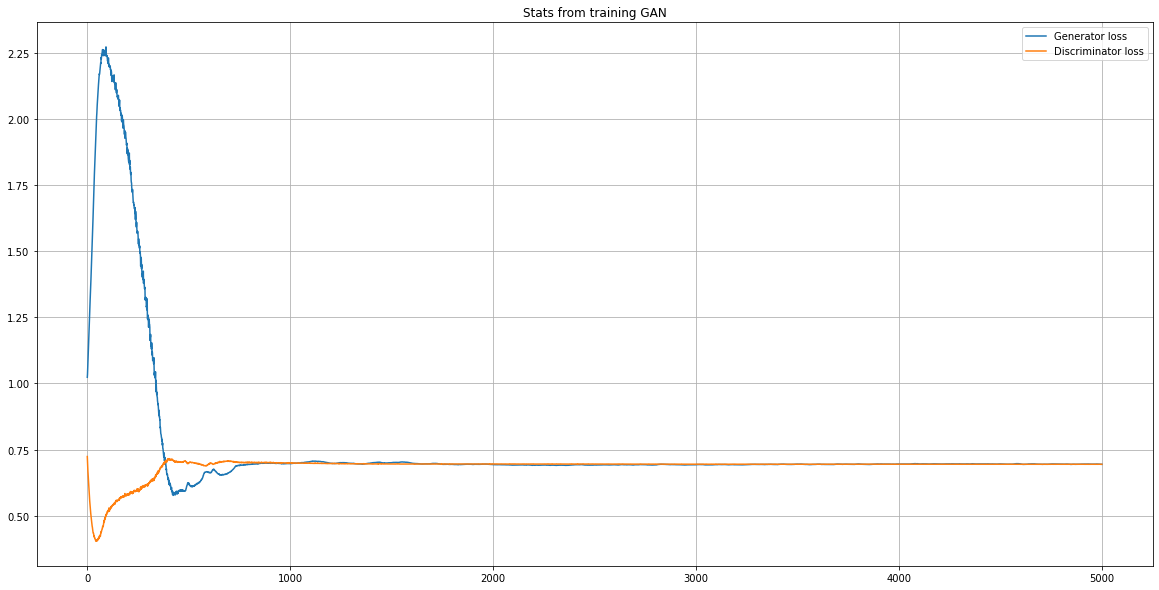

In [148]:
train(gan, generator, discriminator, scaleNumData, latent_dim, n_epochs = 5000, n_batch = 8000, n_eval = 100)

In [149]:
noise = np.random.normal(0, 1, (10000, latent_dim))
generated_numerical_data = generator.predict(noise)
generated_numerical_data

array([[4.62849736e-02, 1.29351914e-02, 1.16705894e-01, 4.29445088e-01],
       [2.66513228e-03, 3.91134620e-02, 2.53364563e-01, 9.94389892e-01],
       [1.36128455e-01, 4.74721193e-04, 1.49945796e-01, 1.02650574e-05],
       ...,
       [7.87543952e-02, 5.01155853e-04, 1.14180952e-01, 4.89935040e-01],
       [5.78720272e-02, 1.11536384e-02, 1.37649804e-01, 3.59406173e-01],
       [1.07799798e-01, 1.33624375e-02, 1.45997852e-01, 1.82819664e-01]],
      dtype=float32)

Generated numerical data

In [156]:
generated_numerical_data = np.round(MinMaxFit.inverse_transform(generated_numerical_data))
dataFrameGennCar = pd.DataFrame(data = generated_numerical_data, columns = numData.columns)
dataFrameGennCar

,mileage,price,hp,year
0,5.714193e+10,1.990812e+10,84972.0,22164.0
1,3.290286e+09,5.752948e+10,183475.0,22220.0
2,1.680598e+11,2.000913e+09,108931.0,22121.0
3,1.796668e+11,7.170141e+09,136219.0,22162.0
4,5.176544e+10,3.075806e+09,79564.0,22169.0
...,...,...,...,...
9995,3.437830e+10,2.535278e+10,169670.0,22214.0
9996,3.855195e+10,1.818899e+10,61486.0,22151.0
9997,9.722763e+10,2.038903e+09,83152.0,22170.0
9998,7.144693e+10,1.734782e+10,100068.0,22157.0


In [33]:
dataFrameGennCar.to_csv('autoinfo_gen_data.csv', encoding='utf-8')

**Categorical Data from car info**

In [34]:
def build_generator(n_columns, latent_dim):
    model = Sequential()
    model.add(Dense(32, kernel_initializer = "he_uniform", input_dim=latent_dim))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(64,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(128,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(n_columns, activation = "sigmoid"))
    return model

In [53]:
latent_dim = 100
generatorCat = build_generator(offerTypeCat.shape[1], latent_dim)

In [36]:
optimizer = Adam(lr=0.0002, beta_1=0.5)

In [37]:
def build_discriminator(inputs_n):
	model = Sequential()
	model.add(Dense(128,  kernel_initializer = "he_uniform", input_dim = inputs_n))
	model.add(LeakyReLU(0.2))
	model.add(Dense(64,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dense(32,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dense(16,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dense(1, activation = "sigmoid"))
	model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
	return model

In [54]:
discriminatorCat = build_discriminator(offerTypeCat.shape[1])

In [39]:
def build_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect generator and dicriminator
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss = "binary_crossentropy", optimizer = optimizer)
	return model

In [55]:
ganCat = build_gan(generatorCat, discriminatorCat)

In [41]:
def train(gan, generator, discriminator, data, latent_dim, n_epochs, n_batch, n_eval):
    #Half batch size for updateting discriminator
    half_batch = int(n_batch / 2)

    #lists for stats from the model
    generator_loss = []
    discriminator_loss = []

    #generate class labels for fake = 0 and real = 1
    valid = np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))
    y_gan = np.ones((n_batch, 1))
    #training loop
    for i in range(n_epochs):
        
        #select random batch from the real numerical data
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_data = data[idx]
        
        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(noise)

        #train the discriminator and return losses
        d_loss_real, _ = discriminator.train_on_batch(real_data, valid)
        d_loss_fake, _ = discriminator.train_on_batch(fake_data, fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator_loss.append(d_loss)

        #generate noise for generator input and  train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, latent_dim))
        g_loss = gan.train_on_batch(noise, y_gan)
        generator_loss.append(g_loss)

        #evaluate progress
        if (i+1) % n_eval == 0:
            print ("Epoch: %d [Generator loss: %f] [Discriminator loss: %f]" % (i + 1, g_loss, d_loss))

    #plot losses after training
    plt.figure(figsize = (20, 10))
    plt.plot(generator_loss, label = "Generator loss")
    plt.plot(discriminator_loss, label = "Discriminator loss")
    plt.title("Stats from training GAN")
    plt.legend()
    plt.grid()

Epoch: 100 [Generator loss: 2.183160] [Discriminator loss: 0.393018]
Epoch: 200 [Generator loss: 1.183752] [Discriminator loss: 0.530598]
Epoch: 300 [Generator loss: 1.003316] [Discriminator loss: 0.614887]
Epoch: 400 [Generator loss: 0.942366] [Discriminator loss: 0.645229]
Epoch: 500 [Generator loss: 0.895916] [Discriminator loss: 0.660169]
Epoch: 600 [Generator loss: 0.870303] [Discriminator loss: 0.674987]
Epoch: 700 [Generator loss: 0.842646] [Discriminator loss: 0.687486]
Epoch: 800 [Generator loss: 0.811712] [Discriminator loss: 0.689657]
Epoch: 900 [Generator loss: 0.797929] [Discriminator loss: 0.692130]
Epoch: 1000 [Generator loss: 0.778531] [Discriminator loss: 0.697813]
Epoch: 1100 [Generator loss: 0.778556] [Discriminator loss: 0.698522]
Epoch: 1200 [Generator loss: 0.764090] [Discriminator loss: 0.701522]
Epoch: 1300 [Generator loss: 0.760595] [Discriminator loss: 0.703025]
Epoch: 1400 [Generator loss: 0.758534] [Discriminator loss: 0.704871]
Epoch: 1500 [Generator loss: 

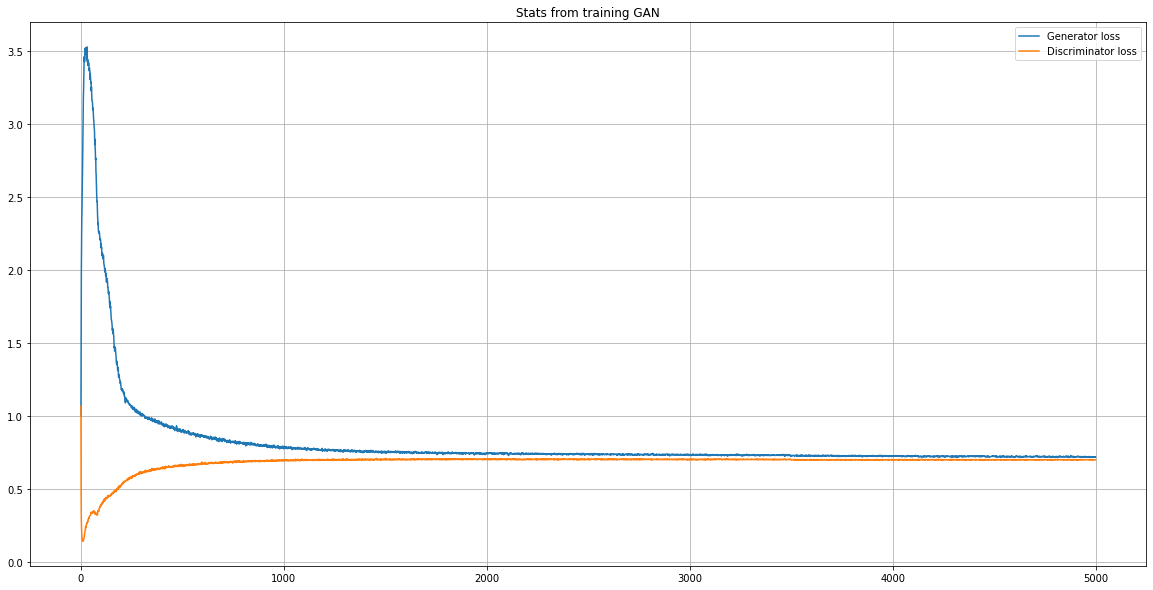

In [56]:
train(ganCat, generatorCat, discriminatorCat, offerTypeCat.values, latent_dim, n_epochs = 5000, n_batch = 8000, n_eval = 100)

In [57]:
noise = np.random.normal(0, 1, (10000, latent_dim))
generated_categorical_data = generator.predict(noise)
generated_categorical_data

array([[0.09139833, 0.00958043, 0.1652062 , 0.4092819 ],
       [0.00647959, 0.09373796, 0.6102233 , 0.9244083 ],
       [0.03143305, 0.00934401, 0.09392911, 0.68369406],
       ...,
       [0.01180825, 0.00573608, 0.08098203, 0.44684184],
       [0.08734697, 0.00494346, 0.19569376, 0.12746072],
       [0.04351503, 0.00544822, 0.07762125, 0.440135  ]], dtype=float32)

Generated Categorical data

In [63]:
dataFrameGencCar = pd.DataFrame(data = np.round(generated_categorical_data), columns = offerTypeCat.columns[0:4])
dataFrameGencCar

,offerType_Demonstration,offerType_Employee's car,offerType_New,offerType_Pre-registered
0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0
...,...,...,...,...
9995,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,1.0
9997,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0


**Categorical and numerical data from car info**

In [66]:
def build_generator(categorical_data_shape, categorical_data_shape2, numerical_data_shape):
    #noise as input from the latent space
    noise = Input(shape = (100,))
    hidden_1 = Dense(8, kernel_initializer = "he_uniform")(noise)
    hidden_1 = LeakyReLU(0.2)(hidden_1)
    hidden_1 = BatchNormalization(momentum = 0.8)(hidden_1)

    hidden_2 = Dense(16, kernel_initializer = "he_uniform")(hidden_1)
    hidden_2 = LeakyReLU(0.2)(hidden_2)
    hidden_2 = BatchNormalization(momentum = 0.8)(hidden_2)

    #Branch 1 for generating categorical gender data
    branch_1 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_1 = LeakyReLU(0.2)(branch_1)
    branch_1 = BatchNormalization(momentum = 0.8)(branch_1)

    branch_1 = Dense(64, kernel_initializer = "he_uniform")(branch_1)
    branch_1 = LeakyReLU(0.2)(branch_1)
    branch_1 = BatchNormalization(momentum=0.8)(branch_1)
    #Output 1 layer, softmax activation for multi classification
    branch_1_output = Dense(categorical_data_shape, activation = "softmax")(branch_1)

    #Branch 2 for generating categorical bmi_class data
    branch_2 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_2 = LeakyReLU(0.2)(branch_2)
    branch_2 = BatchNormalization(momentum=0.8)(branch_2)

    branch_2 = Dense(64, kernel_initializer = "he_uniform")(branch_2)
    branch_2 = LeakyReLU(0.2)(branch_2)
    branch_2 = BatchNormalization(momentum=0.8)(branch_2)
    #Output 2 layer, softmax activation for multi classification
    branch_2_output = Dense(categorical_data_shape2, activation = "softmax")(branch_2)

    #Branch 3 for generating numerical data
    branch_3 = Dense(64, kernel_initializer = "he_uniform")(hidden_2)
    branch_3 = LeakyReLU(0.2)(branch_3)
    branch_3 = BatchNormalization(momentum=0.8)(branch_3)

    branch_3 = Dense(128, kernel_initializer = "he_uniform")(branch_3)
    branch_3 = LeakyReLU(0.2)(branch_3)
    branch_3 = BatchNormalization(momentum=0.8)(branch_3)
    #Output 3, sigmoid activation
    branch_3_output = Dense(numerical_data_shape, activation = "sigmoid")(branch_3)

    #Combined output
    combined_output = concatenate([branch_1_output, branch_2_output, branch_3_output])
    #Return model
    return Model(inputs = noise, outputs = combined_output)

In [70]:
generatorCN = build_generator(gearcat.shape[1], offerTypeCat.shape[1], scaleNumData.shape[1])

In [68]:
def build_discriminator(inputs_n):
    #Input from generator
    d_input = Input(shape = (inputs_n,))
    d = Dense(128, kernel_initializer="he_uniform")(d_input)
    d = LeakyReLU(0.2)(d)
    d = Dense(64, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(32, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(16, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(8, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    #Discriminator output for classification, sigmoid activation
    d_output = Dense(1, activation = "sigmoid")(d)
    #compile and return model
    model = Model(inputs = d_input, outputs = d_output)
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    return model

In [69]:
optimizer = Adam(lr=0.0002, beta_1=0.5)

In [71]:
discriminatorCN = build_discriminator(gearcat.shape[1]+offerTypeCat.shape[1]+scaleNumData.shape[1])

In [72]:
def build_gan(generator, discriminator):
    #Make discriminator not trainable
    discriminator.trainable = False
    #Discriminator takes input from generator and make discriminator GAN output
    gan_output = discriminator(generator.output)
    #Initialize gan
    model = Model(inputs = generator.input, outputs = gan_output)
    #Compile model
    model.compile(loss = "binary_crossentropy", optimizer = optimizer)
    #Return Model
    return model

In [73]:
ganCN = build_gan(generatorCN, discriminatorCN)

In [74]:
def train(gan, generator, discriminator, categorical_data, categorical_data2, numerical_data, latent_dim, n_epochs, n_batch, n_eval):
    #Half batch size for updateting discriminator
    half_batch = int(n_batch / 2)

    #lists for stats from the model
    discriminator_loss = []
    generator_loss = []

    #generate class labels for fake and real
    valid = np.ones((half_batch, 1))
    y_gan = np.ones((n_batch, 1))
    fake = np.zeros((half_batch, 1))
    #training loop
    for i in range(n_epochs):

        #select random batch from real categorical and numerical data
        idx = np.random.randint(0, categorical_data.shape[0], half_batch)
        gender_real = categorical_data[idx]
        bmi_real = categorical_data2[idx]
        numerical_real = numerical_data[idx]
        
        #concatenate categorical and numerical data for the discriminator
        real_data = np.concatenate([gender_real, bmi_real, numerical_real], axis = 1)
        
        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(noise)

        #train the discriminator and return losses and acc
        d_loss_real, da_real = discriminator.train_on_batch(real_data, valid)
        d_loss_fake, da_fake = discriminator.train_on_batch(fake_data, fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator_loss.append(d_loss)
    
        #generate noise for generator input and train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, latent_dim))
        g_loss = gan.train_on_batch(noise, y_gan)

        generator_loss.append(g_loss)
        #evaluate progress
        if (i+1) % n_eval == 0:
            print ("Epoch: %d [Discriminator loss: %f] [Generator loss: %f]" % (i + 1, d_loss, g_loss))
    plt.figure(figsize = (20, 10))
    plt.plot(generator_loss, label = "Generator loss")
    plt.plot(discriminator_loss, label = "Discriminator loss")
    plt.title("Stats from training GAN")
    plt.grid()
    plt.legend()

Epoch: 100 [Discriminator loss: 0.283308] [Generator loss: 2.320179]
Epoch: 200 [Discriminator loss: 0.432219] [Generator loss: 2.240910]
Epoch: 300 [Discriminator loss: 0.529705] [Generator loss: 1.657364]
Epoch: 400 [Discriminator loss: 0.636260] [Generator loss: 0.961035]
Epoch: 500 [Discriminator loss: 0.684987] [Generator loss: 0.851278]
Epoch: 600 [Discriminator loss: 0.685915] [Generator loss: 0.809800]
Epoch: 700 [Discriminator loss: 0.688259] [Generator loss: 0.801295]
Epoch: 800 [Discriminator loss: 0.689037] [Generator loss: 0.780632]
Epoch: 900 [Discriminator loss: 0.694063] [Generator loss: 0.772360]
Epoch: 1000 [Discriminator loss: 0.691855] [Generator loss: 0.762755]
Epoch: 1100 [Discriminator loss: 0.714441] [Generator loss: 0.751967]
Epoch: 1200 [Discriminator loss: 0.701030] [Generator loss: 0.737063]
Epoch: 1300 [Discriminator loss: 0.699611] [Generator loss: 0.739009]
Epoch: 1400 [Discriminator loss: 0.698549] [Generator loss: 0.735333]
Epoch: 1500 [Discriminator lo

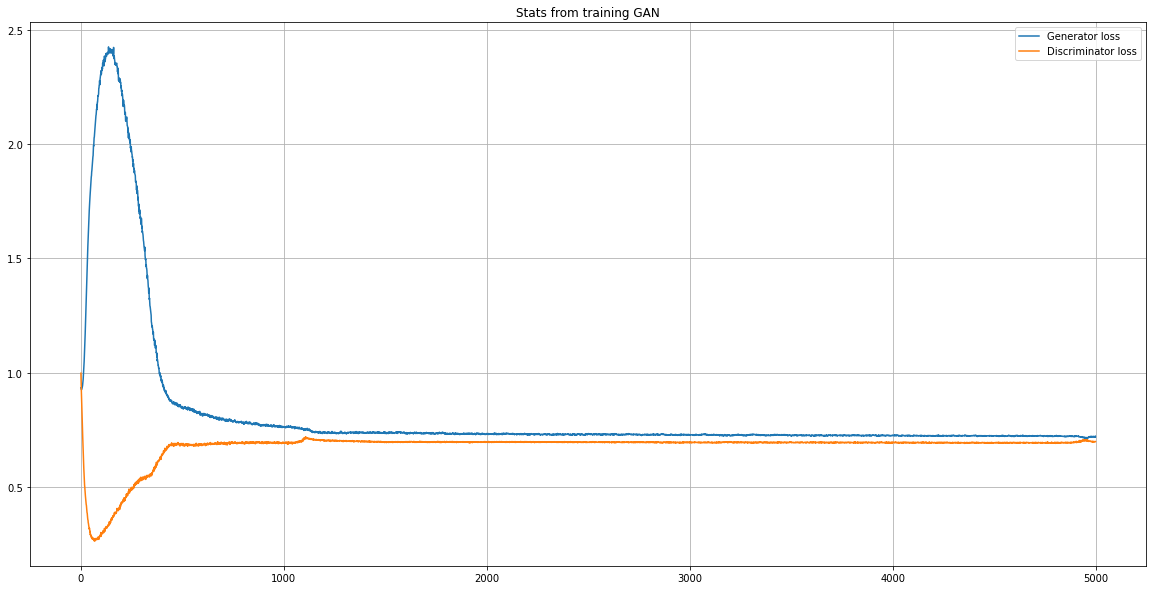

In [76]:
latent_dim = 100
train(ganCN, generatorCN, discriminatorCN, gearcat.values, offerTypeCat.values, scaleNumData, latent_dim, n_epochs = 5000, n_batch = 8000, n_eval = 100)

In [77]:
noise = np.random.normal(0, 1, (10000, 100))
generated_mixed_data = generatorCN.predict(noise)
generated_mixed_data

array([[2.6741748e-10, 9.9999952e-01, 5.1878641e-07, ..., 3.8404763e-03,
        8.7313414e-02, 2.9032725e-01],
       [1.0000000e+00, 3.9619322e-15, 1.5265986e-08, ..., 2.4574280e-02,
        2.9956156e-01, 6.9668502e-01],
       [1.3514890e-18, 1.0000000e+00, 1.4446680e-12, ..., 1.1647880e-02,
        1.0175386e-01, 6.5496260e-01],
       ...,
       [2.1608583e-12, 1.0000000e+00, 2.5144642e-08, ..., 4.6439290e-02,
        1.2771344e-01, 8.7182599e-01],
       [5.5767963e-11, 9.9999976e-01, 2.2883658e-07, ..., 1.2466609e-03,
        8.9821011e-02, 2.4270314e-01],
       [1.0000000e+00, 1.3321186e-36, 3.1169728e-14, ..., 5.9223175e-03,
        4.4260019e-01, 9.9899673e-01]], dtype=float32)

In [79]:
columns = list(gearcat.columns) + list(offerTypeCat.columns) + list(numData.columns)

In [80]:
mixed_gen_df = pd.DataFrame(data = generated_mixed_data, columns = columns)
mixed_gen_df

,gear_Automatic,gear_Manual,gear_Semi-automatic,offerType_Demonstration,offerType_Employee's car,offerType_New,offerType_Pre-registered,offerType_Used,mileage,price,hp,year
0,2.674175e-10,9.999995e-01,5.187864e-07,1.777946e-06,7.554780e-07,1.393797e-06,2.361038e-07,0.999996,5.439639e-02,0.003840,0.087313,0.290327
1,1.000000e+00,3.961932e-15,1.526599e-08,2.548076e-07,2.479960e-06,1.491318e-06,1.947465e-07,0.999996,8.571312e-02,0.024574,0.299562,0.696685
2,1.351489e-18,1.000000e+00,1.444668e-12,1.197348e-06,3.850367e-06,2.561267e-06,7.468164e-07,0.999992,4.073513e-02,0.011648,0.101754,0.654963
3,3.462070e-16,1.000000e+00,1.291662e-11,1.978999e-05,5.905353e-06,5.878675e-06,6.018571e-06,0.999962,7.788342e-02,0.004090,0.093137,0.537692
4,3.482828e-15,1.000000e+00,1.554972e-11,1.028533e-05,3.673513e-06,7.414184e-06,2.144179e-05,0.999957,9.877163e-02,0.000636,0.080610,0.203595
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.000000e+00,2.211219e-17,4.819808e-09,5.400082e-06,8.247021e-06,7.706691e-06,1.244439e-05,0.999966,1.286331e-01,0.002547,0.297564,0.613689
9996,1.000000e+00,5.335611e-24,4.778249e-10,5.522099e-05,2.583079e-05,1.527783e-05,2.536773e-05,0.999878,1.840257e-01,0.003247,0.239782,0.509906
9997,2.160858e-12,1.000000e+00,2.514464e-08,1.807753e-12,5.236165e-09,2.014601e-10,1.234376e-11,1.000000,3.054291e-03,0.046439,0.127713,0.871826
9998,5.576796e-11,9.999998e-01,2.288366e-07,4.210012e-06,1.186611e-06,1.893926e-06,2.562639e-07,0.999992,7.300138e-02,0.001247,0.089821,0.242703


In [81]:
MinMaxFit = MinMaxScaler()

In [85]:
mixed_gen_df.iloc[:, 0:8] = np.round(mixed_gen_df.iloc[:, 0:8])
mixed_gen_df.iloc[:, 8:12] = np.round(MinMaxFit.inverse_transform(mixed_gen_df.iloc[:, 8:12]))
mixed_gen_df


,gear_Automatic,gear_Manual,gear_Semi-automatic,offerType_Demonstration,offerType_Employee's car,offerType_New,offerType_Pre-registered,offerType_Used,mileage,price,hp,year
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,60440.0,5704.0,75.0,2014.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,95237.0,30560.0,255.0,2018.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,45261.0,15063.0,87.0,2018.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,86537.0,6003.0,80.0,2016.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,109746.0,1863.0,69.0,2013.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,142926.0,4154.0,254.0,2017.0
9996,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,204473.0,4992.0,205.0,2016.0
9997,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3394.0,56771.0,109.0,2020.0
9998,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,81113.0,2594.0,77.0,2013.0


 **Reading Data**

***Students Performance dataset***

In [87]:
dataFstdu = pd.read_csv(r"/content/StudentsPerformance.csv")
dataFstdu

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


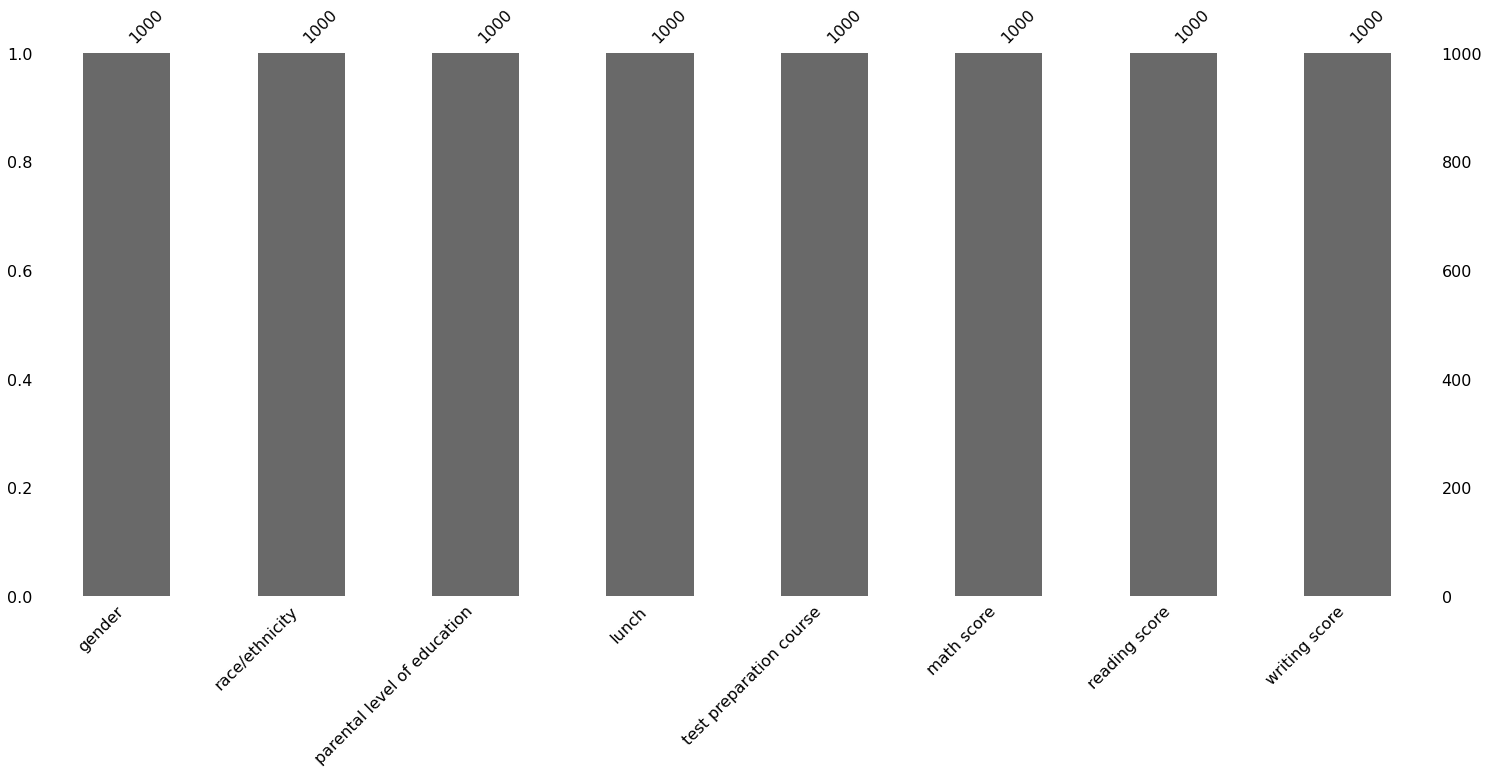

In [88]:
import missingno as msno 
msno.bar(dataFstdu)

In [89]:
numDataStd = dataFstdu.select_dtypes("number")
catDataStd = dataFstdu.select_dtypes("object")

In [90]:
numDataStd

,math score,reading score,writing score
0,72,72,74
1,69,90,88
2,90,95,93
3,47,57,44
4,76,78,75
...,...,...,...
995,88,99,95
996,62,55,55
997,59,71,65
998,68,78,77


In [91]:
catDataStd

,gender,race/ethnicity,parental level of education,lunch,test preparation course
0,female,group B,bachelor's degree,standard,none
1,female,group C,some college,standard,completed
2,female,group B,master's degree,standard,none
3,male,group A,associate's degree,free/reduced,none
4,male,group C,some college,standard,none
...,...,...,...,...,...
995,female,group E,master's degree,standard,completed
996,male,group C,high school,free/reduced,none
997,female,group C,high school,free/reduced,completed
998,female,group D,some college,standard,completed


In [92]:
totalColStd=catDataStd.columns
totalColStd

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course'],
      dtype='object')

In [93]:
genderLen = len(catDataStd['gender'].dropna().unique())
ethnicityLen = len(catDataStd['race/ethnicity'].dropna().unique())
pleLen = len(catDataStd['parental level of education'].dropna().unique())
lunchLen = len(catDataStd['lunch'].dropna().unique())
tpcLen = len(catDataStd['test preparation course'].dropna().unique())

**Data scaleing**

In [95]:
MinMaxFit = MinMaxScaler()
scaleNumDataStd=MinMaxFit .fit_transform(numDataStd)

In [96]:
scaleNumDataStd

array([[0.72      , 0.6626506 , 0.71111111],
       [0.69      , 0.87951807, 0.86666667],
       [0.9       , 0.93975904, 0.92222222],
       ...,
       [0.59      , 0.65060241, 0.61111111],
       [0.68      , 0.73493976, 0.74444444],
       [0.77      , 0.8313253 , 0.84444444]])

**Cat data replace with dummy data**

In [97]:
dummiCatDataStd = pd.get_dummies(catDataStd)
dummiCatDataStd

,gender_female,gender_male,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_associate's degree,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,lunch_free/reduced,lunch_standard,test preparation course_completed,test preparation course_none
0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1
1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0
2,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1
3,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1
4,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0
996,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1
997,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0
998,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0


In [98]:
gendercat= dummiCatDataStd.iloc[:, 0:genderLen]
ethnicitycat = dummiCatDataStd.iloc[:, genderLen:genderLen+ethnicityLen]
plecat = dummiCatDataStd.iloc[:, genderLen+ethnicityLen:genderLen+ethnicityLen+pleLen]
lunchcat = dummiCatDataStd.iloc[:, genderLen+ethnicityLen+pleLen:genderLen+ethnicityLen+pleLen+lunchLen]
tpcCat= dummiCatDataStd.iloc[:, genderLen+ethnicityLen+pleLen+lunchLen:]

In [99]:
gendercat

,gender_female,gender_male
0,1,0
1,1,0
2,1,0
3,0,1
4,0,1
...,...,...
995,1,0
996,0,1
997,1,0
998,1,0


In [100]:
print("numerical data shape:", numDataStd.shape)
print("gender data shape:", gendercat.shape)
print("race/ethnicity data shape:", ethnicitycat.shape)
print("parental level of education data shape:", plecat.shape)
print("lunch data shape:", lunchcat.shape)
print("test preparation course data shape:", tpcCat.shape)

numerical data shape: (1000, 3)
gender data shape: (1000, 2)
race/ethnicity data shape: (1000, 5)
parental level of education data shape: (1000, 6)
lunch data shape: (1000, 2)
test preparation course data shape: (1000, 2)


**Numerical Data**

In [101]:
def build_generator(n_columns, latent_dim):
    model = Sequential()
    model.add(Dense(32, kernel_initializer = "he_uniform", input_dim=latent_dim))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(64,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(128,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(n_columns, activation = "sigmoid"))
    return model

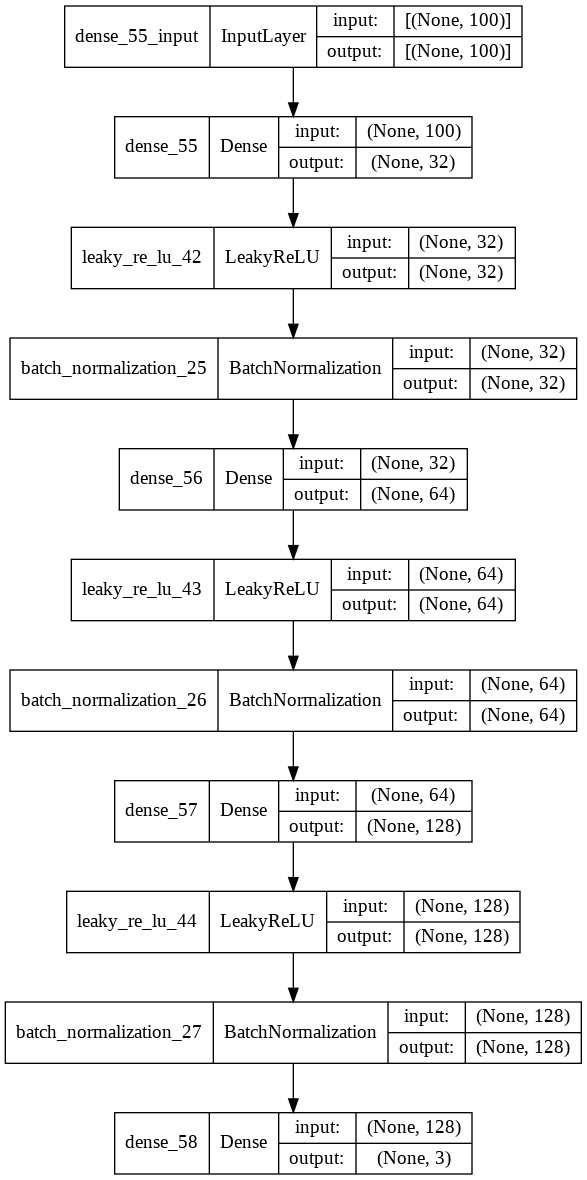

In [102]:
latent_dim = 100
generator1 = build_generator(scaleNumDataStd.shape[1], latent_dim)
plot_model(generator1, show_layer_names = True, show_shapes = True)

In [103]:
optimizer = Adam(lr=0.0002, beta_1=0.5)

In [104]:
def build_discriminator(inputs_n):
	model = Sequential()
	model.add(Dense(128,  kernel_initializer = "he_uniform", input_dim = inputs_n))
	model.add(LeakyReLU(0.2))
	model.add(Dense(64,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dense(32,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dense(16,  kernel_initializer = "he_uniform"))
	model.add(LeakyReLU(0.2))
	model.add(Dense(1, activation = "sigmoid"))
	model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
	return model

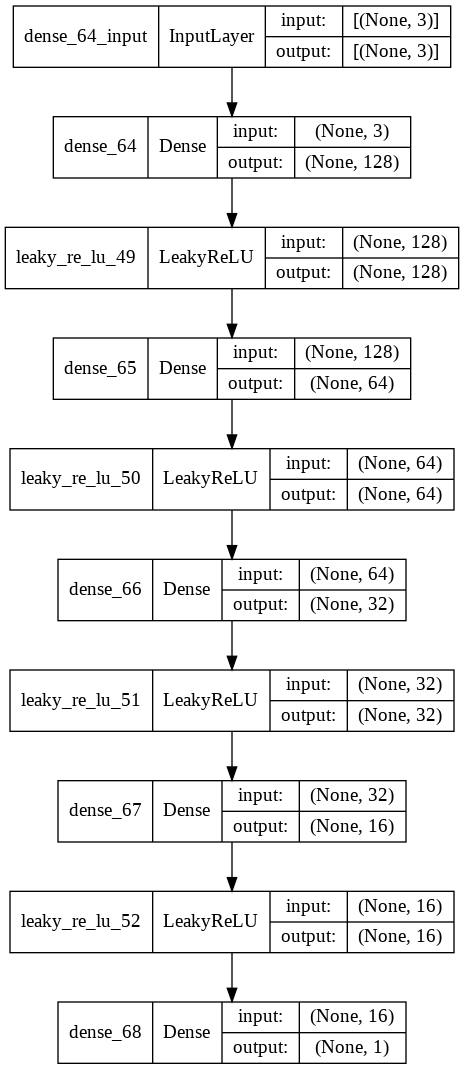

In [106]:
discriminator1 = build_discriminator(scaleNumDataStd.shape[1])
plot_model(discriminator1, show_layer_names = True, show_shapes = True)

In [107]:
def build_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect generator and dicriminator
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss = "binary_crossentropy", optimizer = optimizer)
	return model

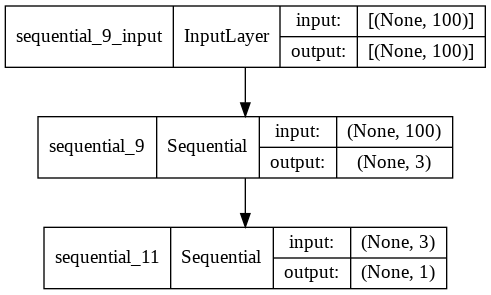

In [108]:
gan1 = build_gan(generator1, discriminator1)
plot_model(gan1, show_layer_names = True, show_shapes = True)

In [109]:
def train(gan, generator, discriminator, data, latent_dim, n_epochs, n_batch, n_eval):
    #Half batch size for updateting discriminator
    half_batch = int(n_batch / 2)

    #lists for stats from the model
    generator_loss = []
    discriminator_loss = []

    #generate class labels for fake = 0 and real = 1
    valid = np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))
    y_gan = np.ones((n_batch, 1))
    #training loop
    for i in range(n_epochs):
        
        #select random batch from the real numerical data
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_data = data[idx]
        
        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(noise)

        #train the discriminator and return losses
        d_loss_real, _ = discriminator.train_on_batch(real_data, valid)
        d_loss_fake, _ = discriminator.train_on_batch(fake_data, fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator_loss.append(d_loss)

        #generate noise for generator input and  train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, latent_dim))
        g_loss = gan.train_on_batch(noise, y_gan)
        generator_loss.append(g_loss)

        #evaluate progress
        if (i+1) % n_eval == 0:
            print ("Epoch: %d [Generator loss: %f] [Discriminator loss: %f]" % (i + 1, g_loss, d_loss))

    #plot losses after training
    plt.figure(figsize = (20, 10))
    plt.plot(generator_loss, label = "Generator loss")
    plt.plot(discriminator_loss, label = "Discriminator loss")
    plt.title("Stats from training GAN")
    plt.legend()
    plt.grid()

Epoch: 100 [Generator loss: 0.654145] [Discriminator loss: 0.691835]
Epoch: 200 [Generator loss: 0.681186] [Discriminator loss: 0.693377]
Epoch: 300 [Generator loss: 0.681955] [Discriminator loss: 0.700277]
Epoch: 400 [Generator loss: 0.707386] [Discriminator loss: 0.700388]
Epoch: 500 [Generator loss: 0.713367] [Discriminator loss: 0.699989]
Epoch: 600 [Generator loss: 0.711662] [Discriminator loss: 0.699450]
Epoch: 700 [Generator loss: 0.709508] [Discriminator loss: 0.699103]
Epoch: 800 [Generator loss: 0.706370] [Discriminator loss: 0.698878]
Epoch: 900 [Generator loss: 0.704142] [Discriminator loss: 0.698372]
Epoch: 1000 [Generator loss: 0.702783] [Discriminator loss: 0.698067]
Epoch: 1100 [Generator loss: 0.701263] [Discriminator loss: 0.697796]
Epoch: 1200 [Generator loss: 0.700301] [Discriminator loss: 0.697604]
Epoch: 1300 [Generator loss: 0.697907] [Discriminator loss: 0.697433]
Epoch: 1400 [Generator loss: 0.697321] [Discriminator loss: 0.697267]
Epoch: 1500 [Generator loss: 

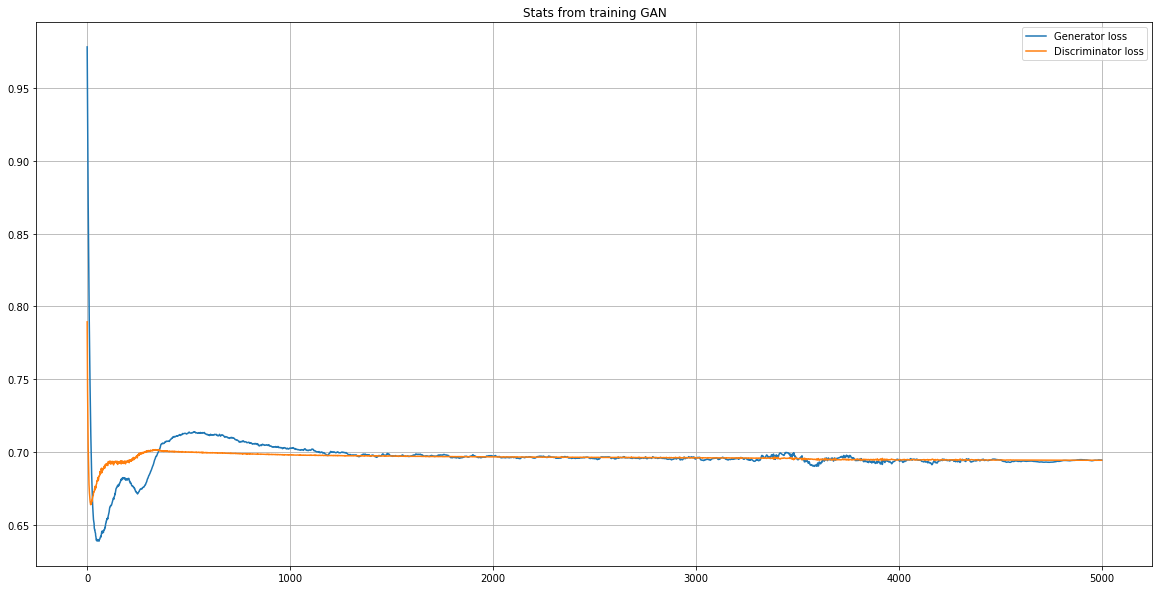

In [110]:
train(gan1, generator1, discriminator1, scaleNumDataStd, latent_dim, n_epochs = 5000, n_batch = 8000, n_eval = 100)

In [111]:
noise = np.random.normal(0, 1, (10000, latent_dim))
generated_numerical_data_Std = generator1.predict(noise)
generated_numerical_data_Std

array([[0.7852747 , 0.69066775, 0.73227006],
       [0.7825222 , 0.7298372 , 0.82805866],
       [0.6403462 , 0.6937353 , 0.70473725],
       ...,
       [0.9781713 , 0.88583803, 0.88499147],
       [0.6411077 , 0.6435299 , 0.6954329 ],
       [0.6247978 , 0.57904756, 0.64964   ]], dtype=float32)

Generated numerical data

In [112]:
generated_numerical_data_Std = np.round(MinMaxFit.inverse_transform(generated_numerical_data_Std))
dataFrameGennStd = pd.DataFrame(data = generated_numerical_data_Std, columns = numDataStd.columns)
dataFrameGennStd

,math score,reading score,writing score
0,79.0,74.0,76.0
1,78.0,78.0,85.0
2,64.0,75.0,73.0
3,86.0,87.0,88.0
4,51.0,60.0,57.0
...,...,...,...
9995,39.0,47.0,54.0
9996,64.0,66.0,68.0
9997,98.0,91.0,90.0
9998,64.0,70.0,73.0


In [113]:
dataFrameGennStd.to_csv('std_prfrm_gen_data.csv', encoding='utf-8')

**Categorical Data**

In [114]:
optimizer = Adam(lr=0.0002, beta_1=0.5)

In [115]:
def build_generator(n_columns, latent_dim):
    model = Sequential()
    model.add(Dense(32, kernel_initializer = "he_uniform", input_dim = latent_dim))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum = 0.8))
    model.add(Dense(64,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum= 0.8))
    model.add(Dense(128,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum = 0.8))
    model.add(Dense(8,  kernel_initializer = "he_uniform"))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum = 0.8))
    model.add(Dense(n_columns, activation = "softmax"))
    return model

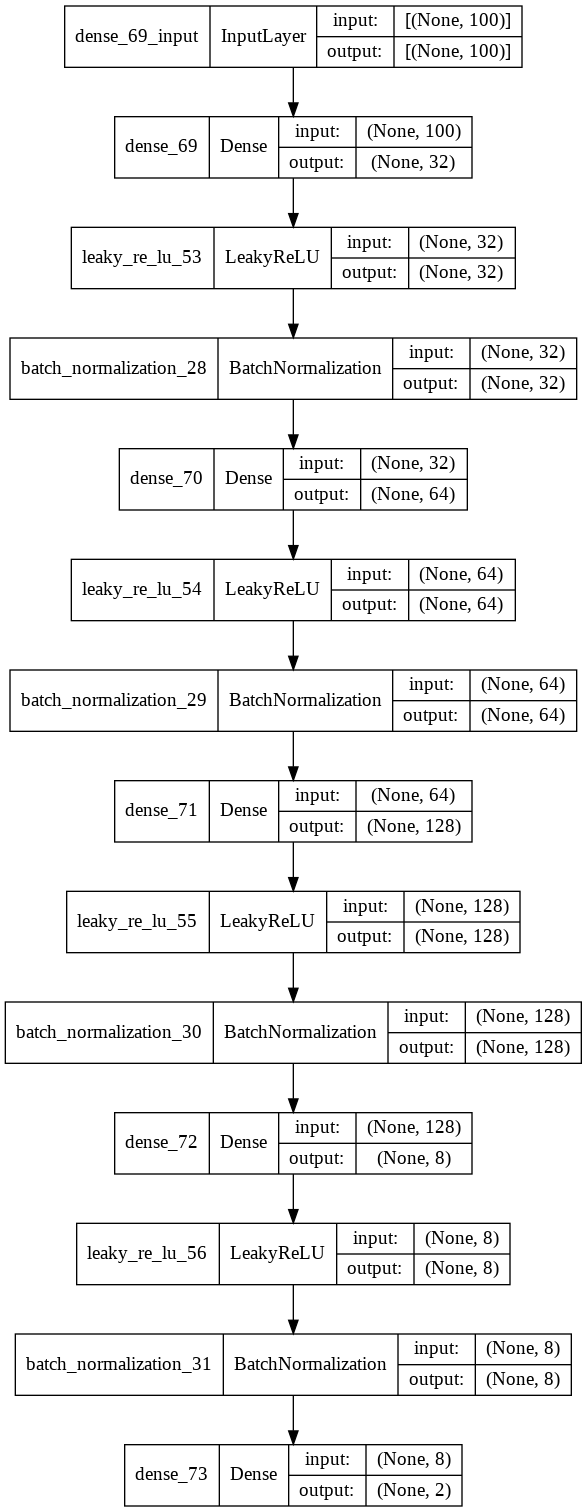

In [116]:
latent_dim = 100
generator1cat = build_generator(gendercat.shape[1], latent_dim)
plot_model(generator1cat, show_layer_names = True, show_shapes = True)

In [117]:
def build_discriminator(inputs_n):
    #Input from generator
    d_input = Input(shape = (inputs_n,))
    d = Dense(128, kernel_initializer="he_uniform")(d_input)
    d = LeakyReLU(0.2)(d)
    d = Dense(64, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(32, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(16, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(8, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    #Discriminator output for classification, sigmoid activation
    d_output = Dense(1, activation = "sigmoid")(d)
    #compile and return model
    model = Model(inputs = d_input, outputs = d_output)
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    return model

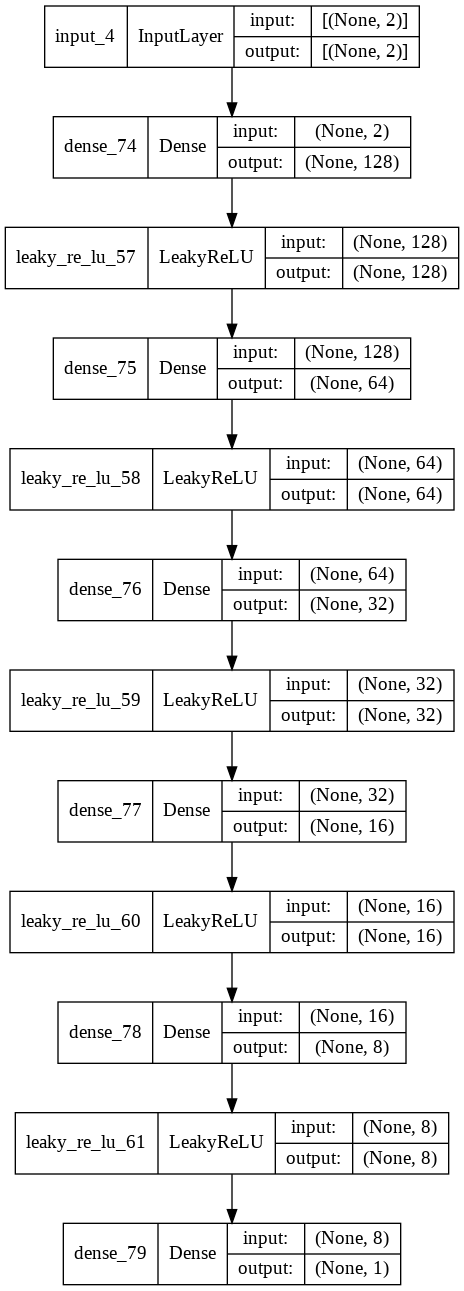

In [118]:
discriminator1cat = build_discriminator(gendercat.shape[1])
plot_model(discriminator1cat, show_layer_names = True, show_shapes = True)

In [119]:
def build_gan(generator, discriminator):
    #Make discriminator not trainable
    discriminator.trainable = False
    #Discriminator takes input from generator and make discriminator GAN output
    gan_output = discriminator(generator.output)
    #Initialize gan
    model = Model(inputs = generator.input, outputs = gan_output)
    #Compile model
    model.compile(loss = "binary_crossentropy", optimizer = optimizer)
    #Return Model
    return model

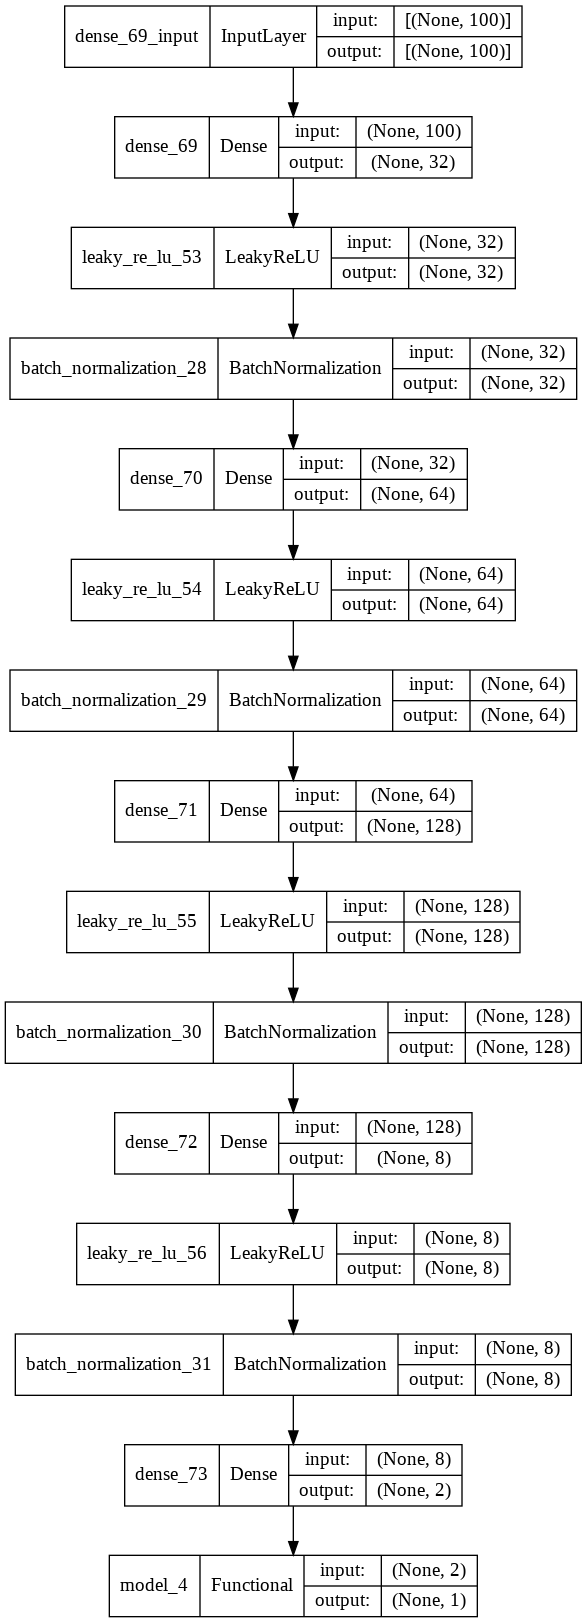

In [120]:
gan1cat = build_gan(generator1cat, discriminator1cat)
plot_model(gan1cat, show_layer_names = True, show_shapes = True)

In [121]:
def train(gan, generator, discriminator, data, latent_dim, n_epochs, n_batch, n_eval):
    #Half batch size for updateting discriminator
    half_batch = int(n_batch / 2)

    #lists for stats from the model
    generator_loss = []
    discriminator_loss = []

    #generate class labels for fake = 0 and real = 1
    valid = np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))
    y_gan = np.ones((n_batch, 1))
    #training loop
    for i in range(n_epochs):
        
        #select random batch from the real numerical data
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_data = data[idx]
        
        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(noise)

        #train the discriminator and return losses
        d_loss_real, _ = discriminator.train_on_batch(real_data, valid)
        d_loss_fake, _ = discriminator.train_on_batch(fake_data, fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator_loss.append(d_loss)

        #generate noise for generator input and  train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, latent_dim))
        g_loss = gan.train_on_batch(noise, y_gan)
        generator_loss.append(g_loss)

        #evaluate progress
        if (i+1) % n_eval == 0:
            print ("Epoch: %d [Generator loss: %f] [Discriminator loss: %f]" % (i + 1, g_loss, d_loss))

    #plot losses after training
    plt.figure(figsize = (20, 10))
    plt.plot(generator_loss, label = "Generator loss")
    plt.plot(discriminator_loss, label = "Discriminator loss")
    plt.title("Stats from training GAN")
    plt.legend()
    plt.grid()

Epoch: 100 [Generator loss: 0.812458] [Discriminator loss: 0.633593]
Epoch: 200 [Generator loss: 0.826866] [Discriminator loss: 0.658496]
Epoch: 300 [Generator loss: 0.792451] [Discriminator loss: 0.679091]
Epoch: 400 [Generator loss: 0.762899] [Discriminator loss: 0.687058]
Epoch: 500 [Generator loss: 0.756508] [Discriminator loss: 0.694970]
Epoch: 600 [Generator loss: 0.741308] [Discriminator loss: 0.695298]
Epoch: 700 [Generator loss: 0.735530] [Discriminator loss: 0.699489]
Epoch: 800 [Generator loss: 0.729388] [Discriminator loss: 0.698746]
Epoch: 900 [Generator loss: 0.725955] [Discriminator loss: 0.697981]
Epoch: 1000 [Generator loss: 0.723788] [Discriminator loss: 0.699487]
Epoch: 1100 [Generator loss: 0.724886] [Discriminator loss: 0.699851]
Epoch: 1200 [Generator loss: 0.722544] [Discriminator loss: 0.701620]
Epoch: 1300 [Generator loss: 0.716647] [Discriminator loss: 0.701173]
Epoch: 1400 [Generator loss: 0.719539] [Discriminator loss: 0.700770]
Epoch: 1500 [Generator loss: 

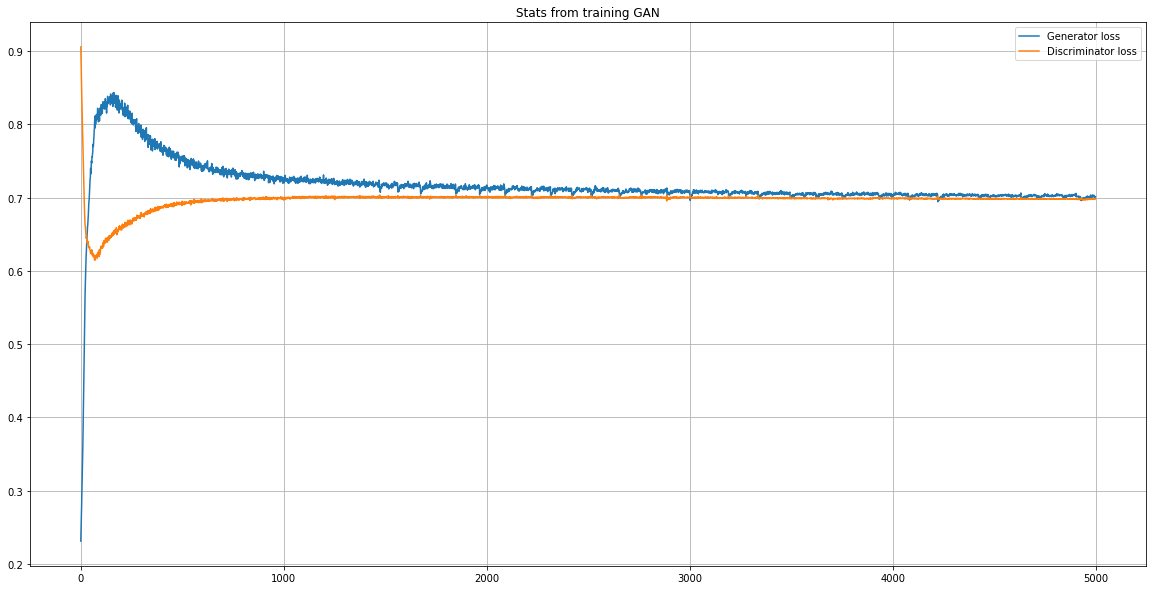

In [122]:
train(gan1cat, generator1cat, discriminator1cat, gendercat.values, latent_dim, n_epochs = 5000, n_batch = 8000, n_eval = 100)

In [124]:
noise = np.random.normal(0, 1, (10000, latent_dim))
generated_categorical_data_Std = generator1cat.predict(noise)
generated_categorical_data_Std

array([[1.0000000e+00, 2.4701562e-08],
       [3.1150671e-04, 9.9968851e-01],
       [9.9181481e-05, 9.9990082e-01],
       ...,
       [3.1237880e-05, 9.9996877e-01],
       [9.9999762e-01, 2.3326575e-06],
       [2.5164009e-05, 9.9997485e-01]], dtype=float32)

Generated Categorical data

In [125]:
dataFrameGencStd = pd.DataFrame(data = np.round(generated_categorical_data_Std), columns = gendercat.columns)
dataFrameGencStd

,gender_female,gender_male
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
...,...,...
9995,1.0,0.0
9996,0.0,1.0
9997,0.0,1.0
9998,1.0,0.0


**Categorical and numerical data from Student Perfomence**

In [126]:
def build_generator(categorical_data_shape, categorical_data_shape2, numerical_data_shape):
    #noise as input from the latent space
    noise = Input(shape = (100,))
    hidden_1 = Dense(8, kernel_initializer = "he_uniform")(noise)
    hidden_1 = LeakyReLU(0.2)(hidden_1)
    hidden_1 = BatchNormalization(momentum = 0.8)(hidden_1)

    hidden_2 = Dense(16, kernel_initializer = "he_uniform")(hidden_1)
    hidden_2 = LeakyReLU(0.2)(hidden_2)
    hidden_2 = BatchNormalization(momentum = 0.8)(hidden_2)

    #Branch 1 for generating categorical gender data
    branch_1 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_1 = LeakyReLU(0.2)(branch_1)
    branch_1 = BatchNormalization(momentum = 0.8)(branch_1)

    branch_1 = Dense(64, kernel_initializer = "he_uniform")(branch_1)
    branch_1 = LeakyReLU(0.2)(branch_1)
    branch_1 = BatchNormalization(momentum=0.8)(branch_1)
    #Output 1 layer, softmax activation for multi classification
    branch_1_output = Dense(categorical_data_shape, activation = "softmax")(branch_1)

    #Branch 2 for generating categorical bmi_class data
    branch_2 = Dense(32, kernel_initializer = "he_uniform")(hidden_2)
    branch_2 = LeakyReLU(0.2)(branch_2)
    branch_2 = BatchNormalization(momentum=0.8)(branch_2)

    branch_2 = Dense(64, kernel_initializer = "he_uniform")(branch_2)
    branch_2 = LeakyReLU(0.2)(branch_2)
    branch_2 = BatchNormalization(momentum=0.8)(branch_2)
    #Output 2 layer, softmax activation for multi classification
    branch_2_output = Dense(categorical_data_shape2, activation = "softmax")(branch_2)

    #Branch 3 for generating numerical data
    branch_3 = Dense(64, kernel_initializer = "he_uniform")(hidden_2)
    branch_3 = LeakyReLU(0.2)(branch_3)
    branch_3 = BatchNormalization(momentum=0.8)(branch_3)

    branch_3 = Dense(128, kernel_initializer = "he_uniform")(branch_3)
    branch_3 = LeakyReLU(0.2)(branch_3)
    branch_3 = BatchNormalization(momentum=0.8)(branch_3)
    #Output 3, sigmoid activation
    branch_3_output = Dense(numerical_data_shape, activation = "sigmoid")(branch_3)

    #Combined output
    combined_output = concatenate([branch_1_output, branch_2_output, branch_3_output])
    #Return model
    return Model(inputs = noise, outputs = combined_output)

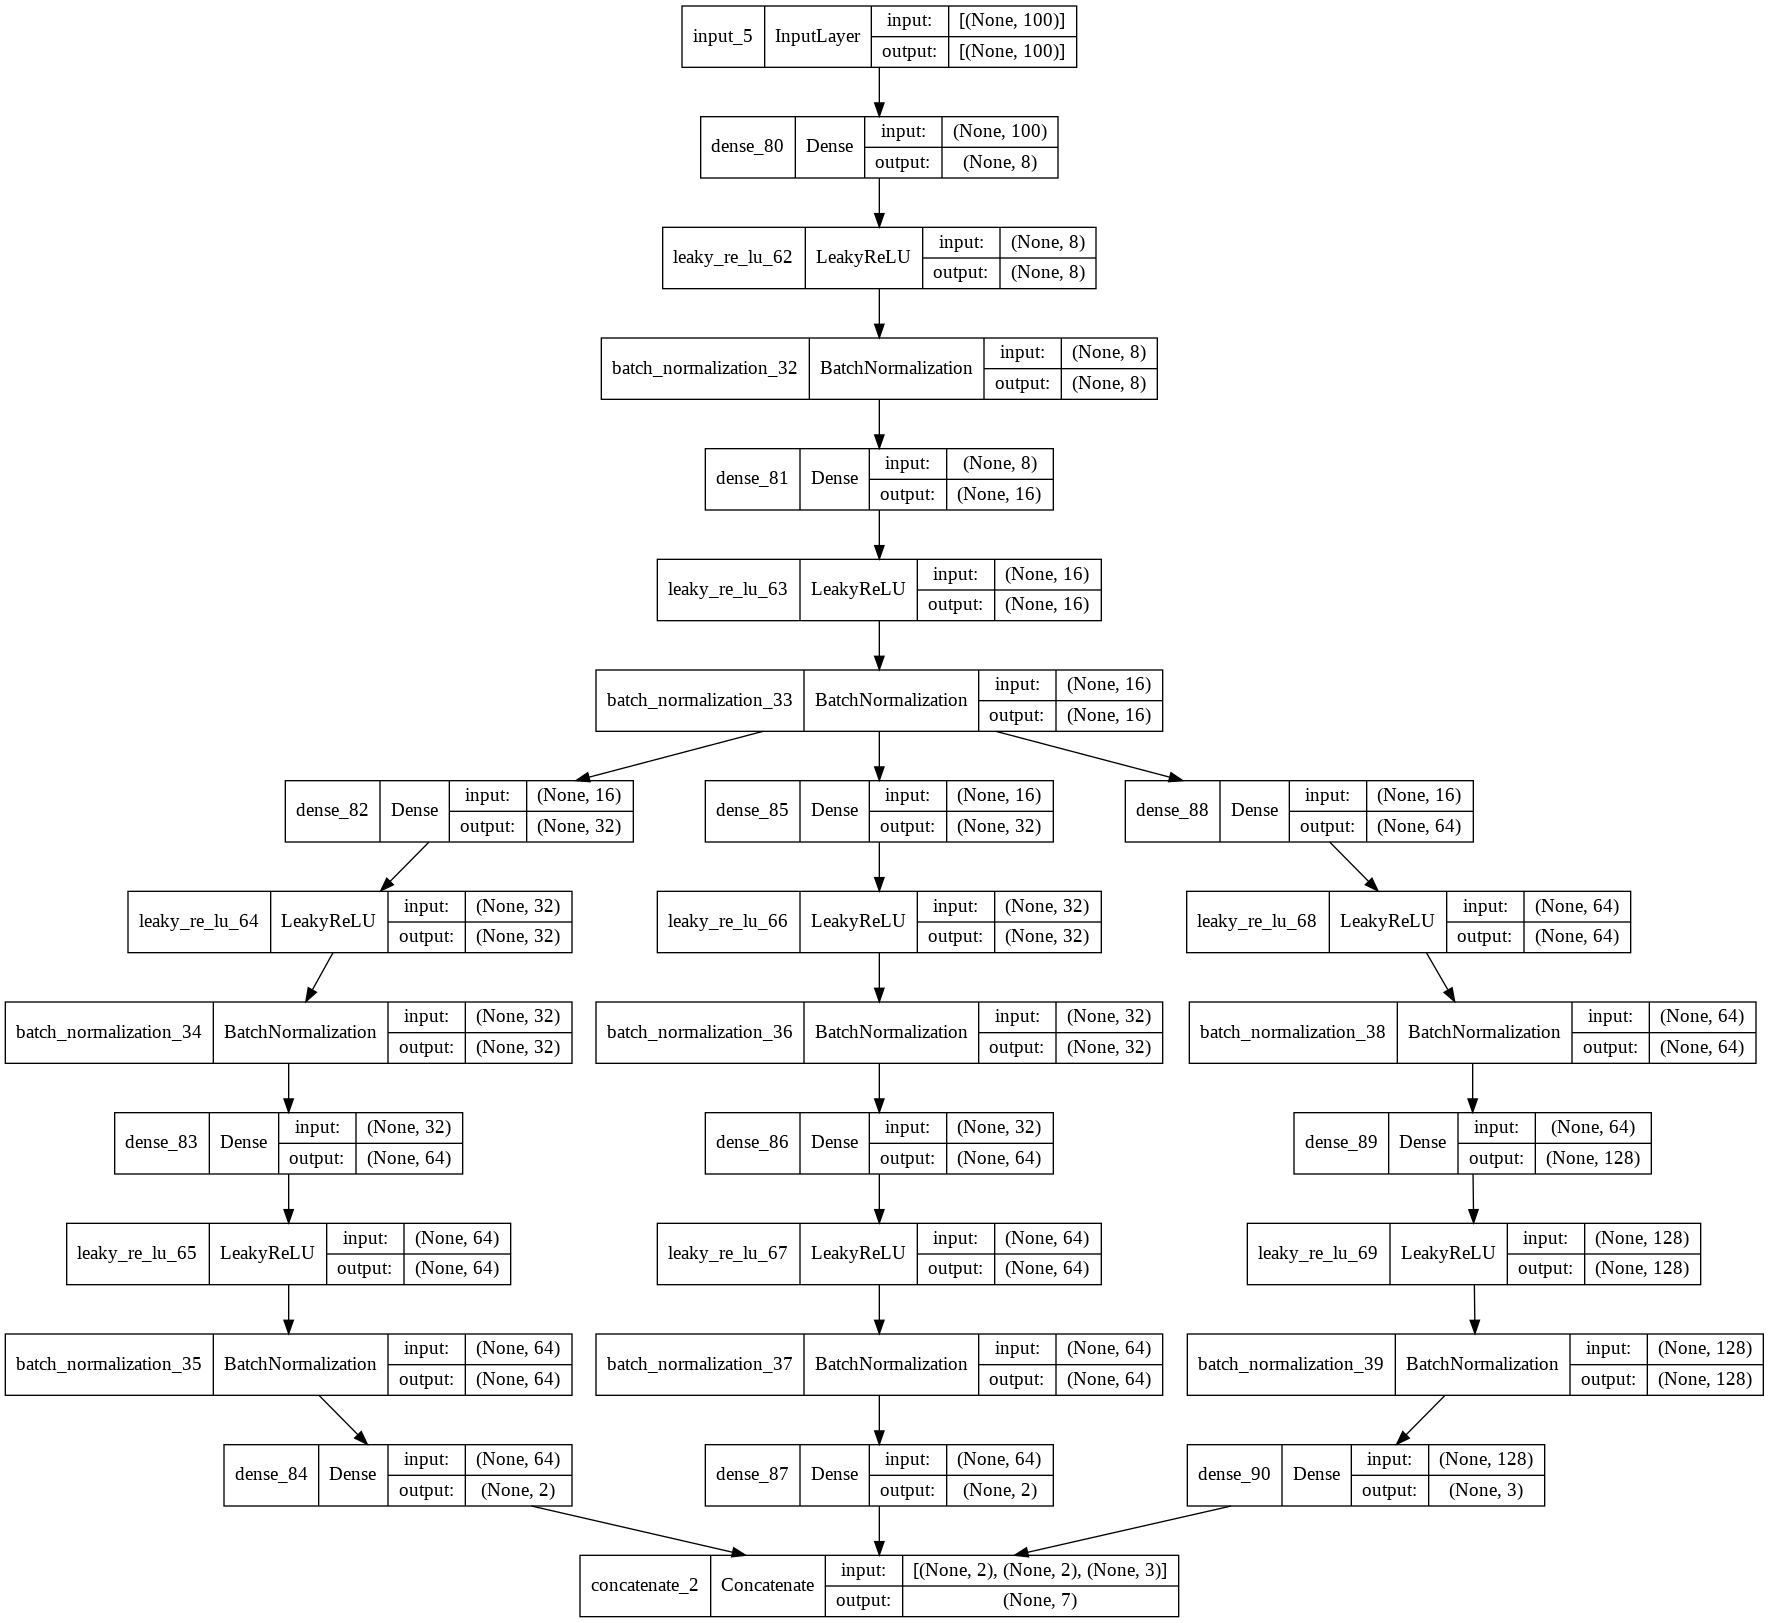

In [127]:
generator1CN = build_generator(gendercat.shape[1], tpcCat.shape[1], scaleNumDataStd.shape[1])
plot_model(generator1CN, show_layer_names = True, show_shapes = True)

In [128]:
def build_discriminator(inputs_n):
    #Input from generator
    d_input = Input(shape = (inputs_n,))
    d = Dense(128, kernel_initializer="he_uniform")(d_input)
    d = LeakyReLU(0.2)(d)
    d = Dense(64, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(32, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(16, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    d = Dense(8, kernel_initializer="he_uniform")(d)
    d = LeakyReLU(0.2)(d)
    #Discriminator output for classification, sigmoid activation
    d_output = Dense(1, activation = "sigmoid")(d)
    #compile and return model
    model = Model(inputs = d_input, outputs = d_output)
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    return model

In [129]:
inputs_n = gendercat.shape[1] + tpcCat.shape[1] + scaleNumDataStd.shape[1]
inputs_n

7

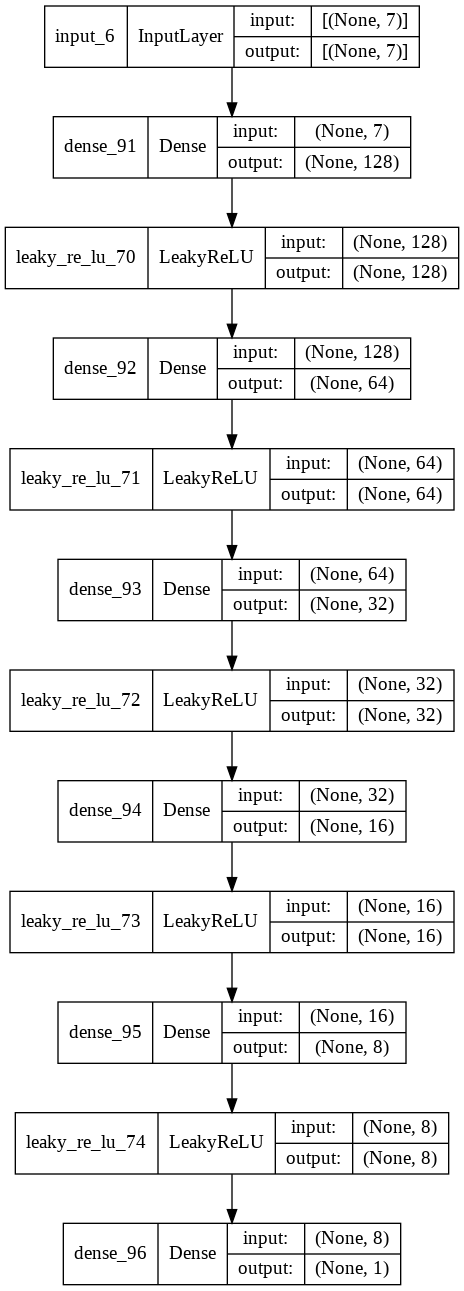

In [130]:
discriminator1CN = build_discriminator(inputs_n)
plot_model(discriminator1CN, show_layer_names = True, show_shapes = True)

In [131]:
def build_gan(generator, discriminator):
    #Make discriminator not trainable
    discriminator.trainable = False
    #Discriminator takes input from generator and make discriminator GAN output
    gan_output = discriminator(generator.output)
    #Initialize gan
    model = Model(inputs = generator.input, outputs = gan_output)
    #Compile model
    model.compile(loss = "binary_crossentropy", optimizer = optimizer)
    #Return Model
    return model

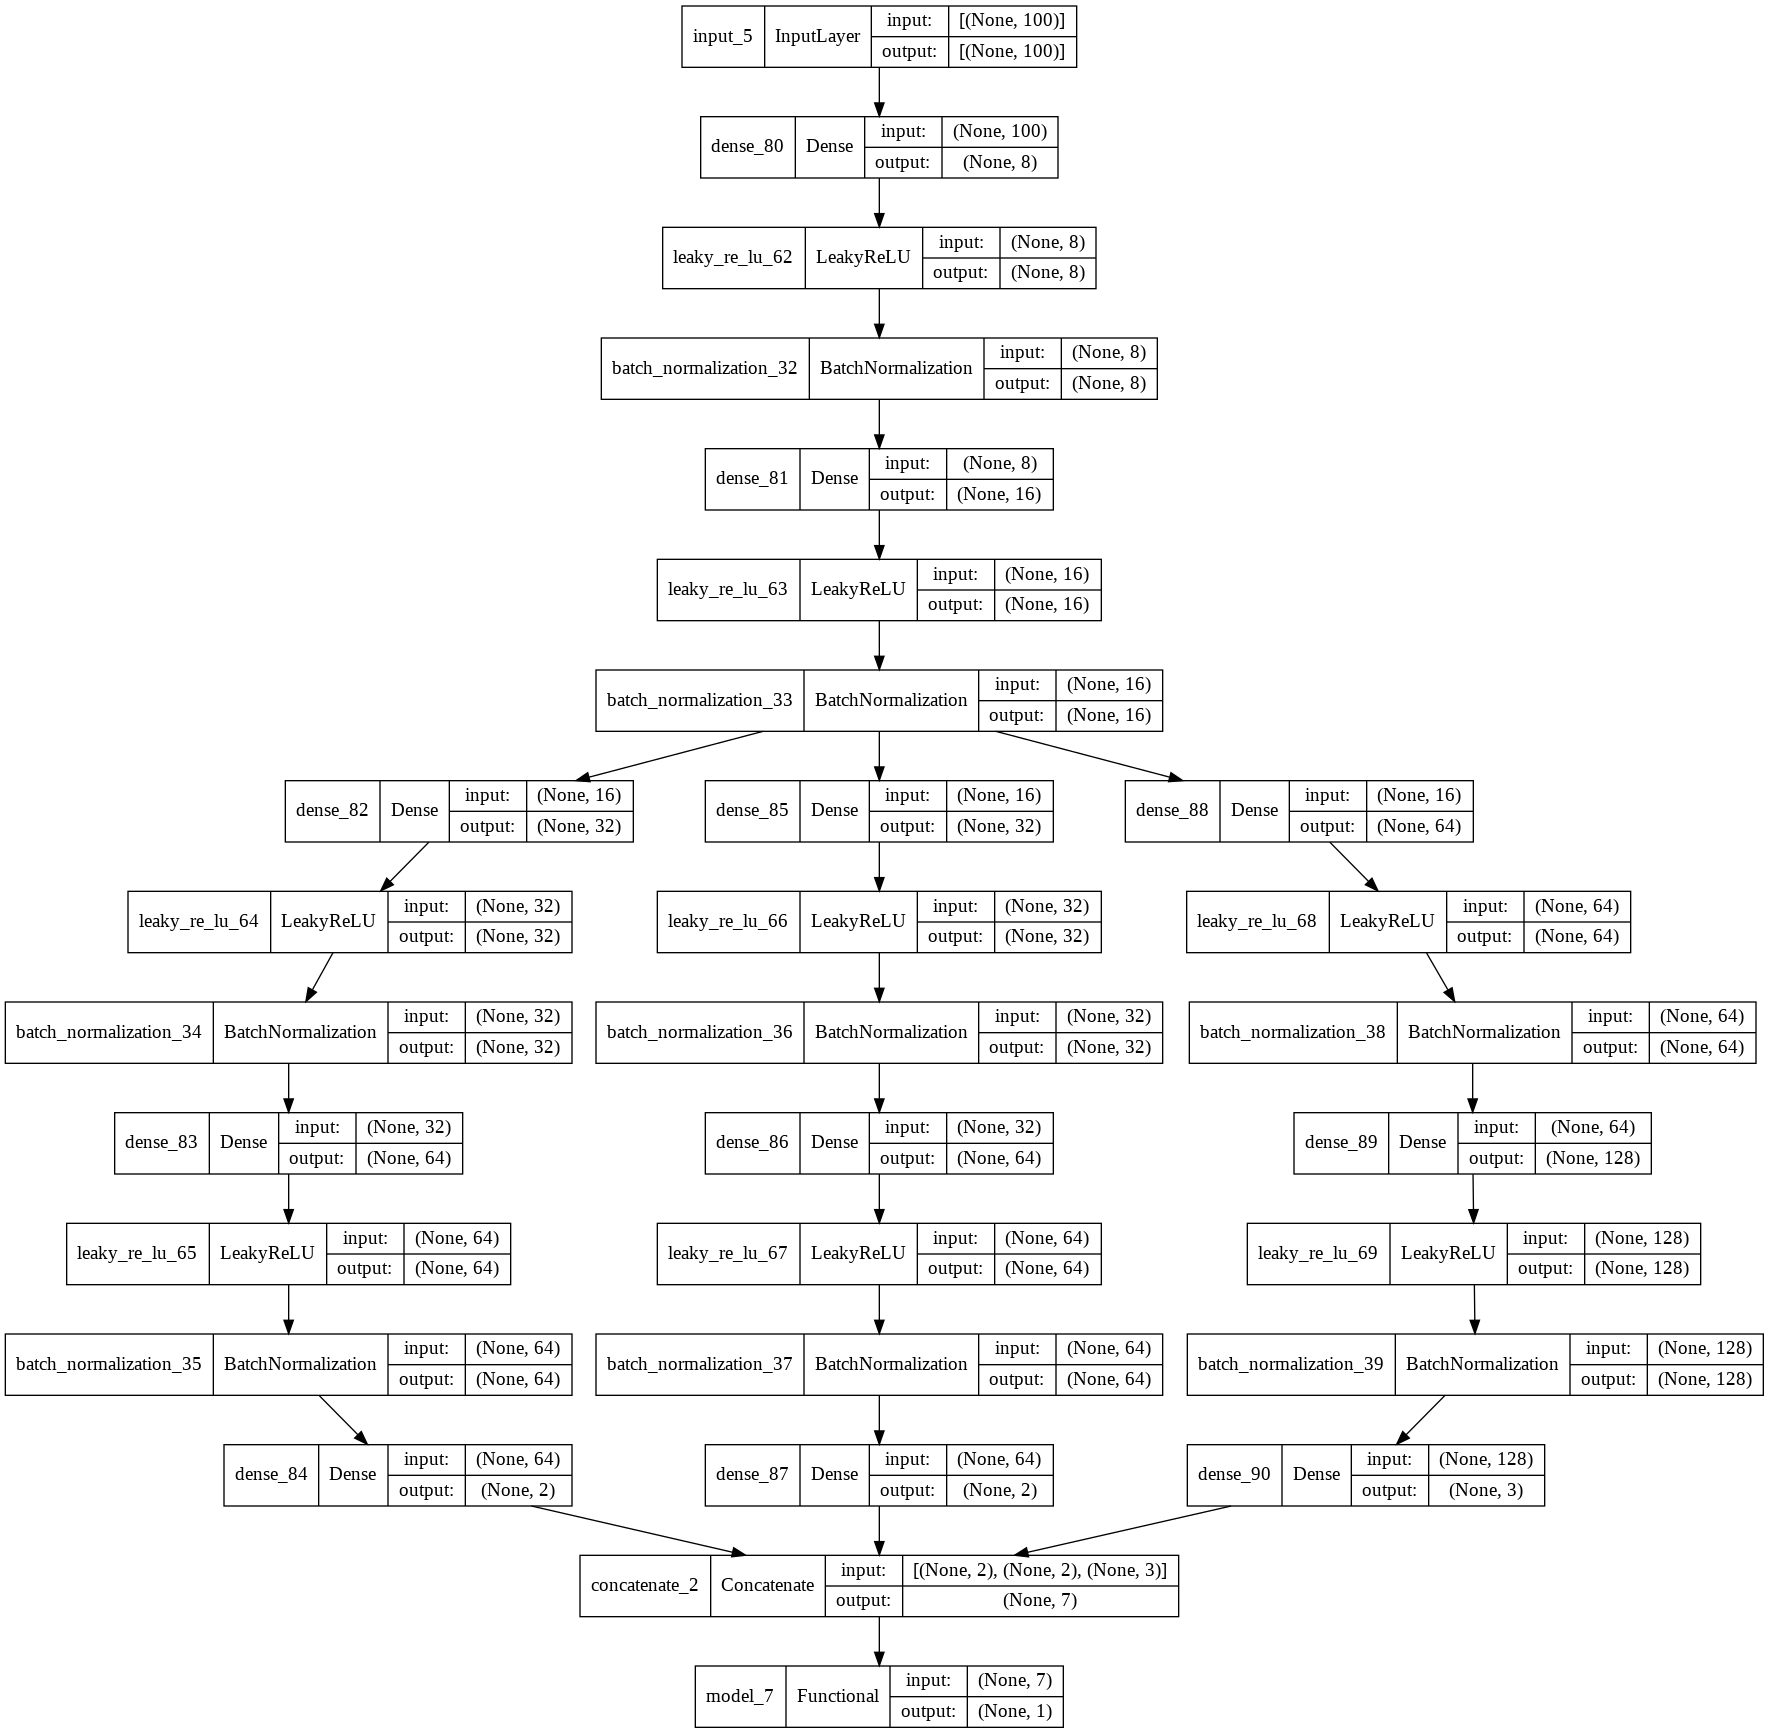

In [132]:
gan1CN = build_gan(generator1CN, discriminator1CN)
plot_model(gan1CN, show_layer_names = True, show_shapes = True)

In [133]:
def train(gan, generator, discriminator, categorical_data, categorical_data2, numerical_data, latent_dim, n_epochs, n_batch, n_eval):
    #Half batch size for updateting discriminator
    half_batch = int(n_batch / 2)

    #lists for stats from the model
    discriminator_loss = []
    generator_loss = []

    #generate class labels for fake and real
    valid = np.ones((half_batch, 1))
    y_gan = np.ones((n_batch, 1))
    fake = np.zeros((half_batch, 1))
    #training loop
    for i in range(n_epochs):

        #select random batch from real categorical and numerical data
        idx = np.random.randint(0, categorical_data.shape[0], half_batch)
        gender_real = categorical_data[idx]
        bmi_real = categorical_data2[idx]
        numerical_real = numerical_data[idx]
        
        #concatenate categorical and numerical data for the discriminator
        real_data = np.concatenate([gender_real, bmi_real, numerical_real], axis = 1)
        
        #generate fake samples from the noise
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_data = generator.predict(noise)

        #train the discriminator and return losses and acc
        d_loss_real, da_real = discriminator.train_on_batch(real_data, valid)
        d_loss_fake, da_fake = discriminator.train_on_batch(fake_data, fake)

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator_loss.append(d_loss)
    
        #generate noise for generator input and train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, latent_dim))
        g_loss = gan.train_on_batch(noise, y_gan)

        generator_loss.append(g_loss)
        #evaluate progress
        if (i+1) % n_eval == 0:
            print ("Epoch: %d [Discriminator loss: %f] [Generator loss: %f]" % (i + 1, d_loss, g_loss))
    plt.figure(figsize = (20, 10))
    plt.plot(generator_loss, label = "Generator loss")
    plt.plot(discriminator_loss, label = "Discriminator loss")
    plt.title("Stats from training GAN")
    plt.grid()
    plt.legend()

Epoch: 100 [Discriminator loss: 0.691433] [Generator loss: 0.699578]
Epoch: 200 [Discriminator loss: 0.690641] [Generator loss: 0.698637]
Epoch: 300 [Discriminator loss: 0.690965] [Generator loss: 0.698836]
Epoch: 400 [Discriminator loss: 0.690442] [Generator loss: 0.701490]
Epoch: 500 [Discriminator loss: 0.692377] [Generator loss: 0.697760]
Epoch: 600 [Discriminator loss: 0.692404] [Generator loss: 0.703448]
Epoch: 700 [Discriminator loss: 0.693181] [Generator loss: 0.703957]
Epoch: 800 [Discriminator loss: 0.691872] [Generator loss: 0.703878]
Epoch: 900 [Discriminator loss: 0.692518] [Generator loss: 0.700835]
Epoch: 1000 [Discriminator loss: 0.692768] [Generator loss: 0.702071]
Epoch: 1100 [Discriminator loss: 0.692489] [Generator loss: 0.701069]
Epoch: 1200 [Discriminator loss: 0.693226] [Generator loss: 0.703017]
Epoch: 1300 [Discriminator loss: 0.693692] [Generator loss: 0.702145]
Epoch: 1400 [Discriminator loss: 0.693509] [Generator loss: 0.701286]
Epoch: 1500 [Discriminator lo

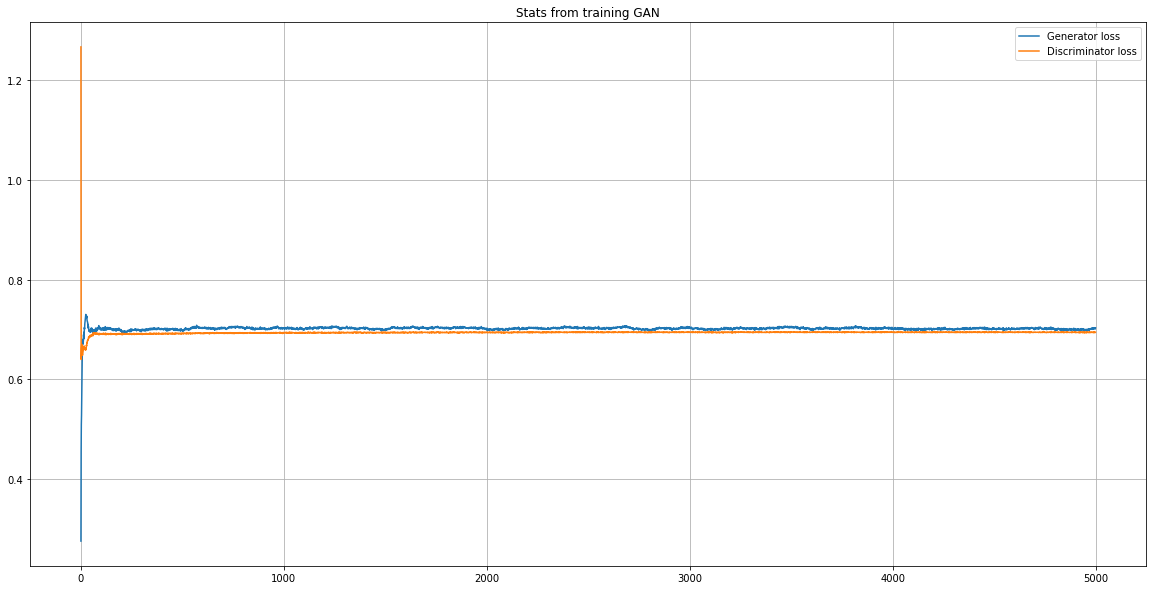

In [134]:
latent_dim = 100
train(gan1CN, generator1CN, discriminator1CN, gendercat.values, tpcCat.values, scaleNumDataStd, latent_dim, n_epochs = 5000, n_batch = 8000, n_eval = 100)

In [135]:
noise = np.random.normal(0, 1, (10000, 100))
generated_mixed_data_Std = generator1CN.predict(noise)
generated_mixed_data_Std

array([[1.0000000e+00, 0.0000000e+00, 2.5901724e-31, ..., 6.4479244e-01,
        6.0081571e-01, 7.1435565e-01],
       [1.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 8.3945131e-01,
        9.4843596e-01, 9.7752523e-01],
       [1.7806434e-19, 1.0000000e+00, 0.0000000e+00, ..., 8.1588757e-01,
        5.4831088e-01, 6.1035937e-01],
       ...,
       [2.4278054e-07, 9.9999976e-01, 2.2476053e-20, ..., 8.7753201e-01,
        8.5908306e-01, 8.4361470e-01],
       [1.0000000e+00, 2.2541624e-15, 1.0000000e+00, ..., 7.4829745e-01,
        7.9863822e-01, 8.2597589e-01],
       [9.3072911e-35, 1.0000000e+00, 1.0000000e+00, ..., 4.7232309e-01,
        3.5264528e-01, 3.6829686e-01]], dtype=float32)

In [136]:
columns = list(gendercat.columns) + list(tpcCat.columns) + list(numDataStd.columns)

In [137]:
dfCatNumStd = pd.DataFrame(data = generated_mixed_data_Std, columns = columns)
dfCatNumStd

,gender_female,gender_male,test preparation course_completed,test preparation course_none,math score,reading score,writing score
0,1.000000e+00,0.000000e+00,2.590172e-31,1.000000e+00,0.644792,0.600816,0.714356
1,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.839451,0.948436,0.977525
2,1.780643e-19,1.000000e+00,0.000000e+00,1.000000e+00,0.815888,0.548311,0.610359
3,6.878167e-23,1.000000e+00,1.297360e-12,1.000000e+00,0.783080,0.741527,0.652091
4,5.857514e-18,1.000000e+00,1.084118e-33,1.000000e+00,0.623586,0.523470,0.425890
...,...,...,...,...,...,...,...
9995,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.926047,0.972711,0.992896
9996,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.595385,0.721557,0.692818
9997,2.427805e-07,9.999998e-01,2.247605e-20,1.000000e+00,0.877532,0.859083,0.843615
9998,1.000000e+00,2.254162e-15,1.000000e+00,0.000000e+00,0.748297,0.798638,0.825976


In [138]:
dfCatNumStd.iloc[:, 0:4] = np.round(dfCatNumStd.iloc[:, 0:4])
dfCatNumStd.iloc[:, 4:7] = np.round(MinMaxFit.inverse_transform(dfCatNumStd.iloc[:, 4:7]))
dfCatNumStd


,gender_female,gender_male,test preparation course_completed,test preparation course_none,math score,reading score,writing score
0,1.0,0.0,0.0,1.0,64.0,67.0,74.0
1,1.0,0.0,1.0,0.0,84.0,96.0,98.0
2,0.0,1.0,0.0,1.0,82.0,63.0,65.0
3,0.0,1.0,0.0,1.0,78.0,79.0,69.0
4,0.0,1.0,0.0,1.0,62.0,60.0,48.0
...,...,...,...,...,...,...,...
9995,1.0,0.0,1.0,0.0,93.0,98.0,99.0
9996,1.0,0.0,0.0,1.0,60.0,77.0,72.0
9997,0.0,1.0,0.0,1.0,88.0,88.0,86.0
9998,1.0,0.0,1.0,0.0,75.0,83.0,84.0
